<a href="https://www.kaggle.com/code/abukhadeejahkarl/motionlabs-power-log-files-pandas?scriptVersionId=133493301" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Motion Labs Power Meter Log file Analysis

This notebook will go through and break down what is in this log file and what the data can inform us of when it comes to corperate events, etc.  This device is often used for event tempoary power, sometimes touring rigs from the USA will have a rack mount version with their video or audio processors.  The version I was using was designed for an in-house indoor usage and had a maximum rating for 100 amps. It took 5 camloc connectors, 1 Ground (green), 1 Neutral (white) and 3 Hots (black, red, blue).  Most large events can use up to 4 different services (maybe more), I would give Lighting 400 amps, audio 100 amps, video 200 amps, and a 80 amp distro for front of house power for some events.  That is some serous power, especially since it's all 3 phase.  





In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

# for interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

logs = []
ignore = [ 'MLabsPy.CSV', 'MLabsPy2.CSV', 'MLabsPy3.CSV']
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        # this file has been edited, so exclude it form the list
        if filename not in ignore:
            logs.append(os.path.join(dirname, filename))


In [2]:
files=random.randint(0, len(logs)-1) 
logs[files]

'/kaggle/input/ml-powerlog/M______L/2018/20180131.CSV'

# Functions to make working with Pandas more easy

These are some of my functions that will save time in my notebook, will eventually port them to a python module.

In [3]:

## plot graph
df = False

#    removes the un needed units, they will be added when i plot

def remove_units(series):
    # Convert the series to string type
    series = series.astype(str)
    # Replace all non-numeric and non-decimal characters with an empty string
    series = series.str.replace('[^0-9\.]+', '', regex=True)
    # Convert the string series to a numeric series
    series = pd.to_numeric(series, errors='coerce')
    return series


# rejoin the data after cleaning

def new_df(df1, df2):
    return pd.concat([df1, df2], axis=1)

    
# used with widgets, load file and run commands
def data_describe():
    global df
    return df.describe()

def data_shape():
    global df
    return df.shape

def data_cols():
    global df
    return df.columns



def graph_types():
    return [ 'line', 'hist', 'bar', 'barh', 'box', 'kde', 'density', 'area', 'pie', 'scatter', 'hexbin' ]
    

def pplot(new, x, color='', title="Plot some data", plot='line'):    
    figsize=(18, 10)
    # Visuals
    if plot == 'line':      # line plot (default)
        return new.plot.line(x=x, color=color, title=title, figsize=figsize)
    elif plot == 'hist':    # histogram
        return new.plot.hist(x=x, color=color, title=title, alpha=0.7, figsize=figsize)
    elif plot == 'bar':     # ‘bar’ : vertical bar plot
        return new.plot.bar(x=x, color=color, title=title, figsize=figsize)
    elif plot == 'barh':    # ‘barh’ : horizontal bar plot
        return new.plot.barh(x=x, color=color, title=title, figsize=figsize)
    elif plot == 'box':     # ‘box’ : boxplot
        return new.plot.box(by=x,  title=title, figsize=figsize)
    elif plot == 'kde':     # ‘kde’ : Kernel Density Estimation plot
        return new.plot.kde(x=x, color=color, title=title, figsize=figsize)
    elif plot == 'density': # ‘density’ : same as ‘kde’
        return new.plot.density(x=x, color=color, title=title, figsize=figsize)
    elif plot == 'area':    # ‘area’ : area plot
        return new.plot.area(x=x, color=color, title=title, figsize=figsize)
    elif plot == 'pie':     # ‘pie’ : pie plot
        return new.plot.pie(x=x, color=color, title=title, figsize=figsize)
    elif plot == 'scatter': # ‘scatter’ : scatter plot (DataFrame only)
        return new.plot.scatter(x=x, color=color, title=title, figsize=figsize)
    elif plot == 'hexbin':  # ‘hexbin’ : hexbin plot (DataFrame only)],
        return new.plot.hexbin(x=x, color=color, title=title, figsize=figsize)

view_data = ['Cols', 'Shape', 'Discribe']
    

def view_pd_data(data):
    if data == 'Cols':
        print("#Data Columns: \n")
        return data_cols()
        
    elif data == 'Shape':
        print("#View Data Shape: \n")
        return data_shape()
        
    elif data == 'Discribe':
        print("#View Data Discription: \n")
        return data_describe()


# Functions for this log file format

In [4]:
def clean_load(file):
    print(file)
    df = load_ml_log(file)
    df.columns = df.columns.str.strip()
    return fix_MLabs_logfile(df)


def set_file(file):
    global df
    df = clean_load(file)


# assumes that there is a 'Record Time' col in the DataFrame, this is one of the fields in the Motions Labs log format
def fix_MLabs_logfile(df):
    df_rc = rc_col(df)
    df_fix = unit_clean(df)
    return new_df(df_rc, df_fix)


# load logfile
def load_ml_log(file, s=2):
    return pd.read_csv(file, sep=';',skiprows=s).drop(columns='Unnamed: 45')


# return the record time col
def rc_col(df):
    return df['Record Time']


# remove the Record Time col and clean the units from the data
def unit_clean(df):
    return df.drop(columns='Record Time').apply(remove_units)


def get_color(ptype='v120'):
    global color
    if ptype in color:
        return color[ptype]
    else:
        return color['v120']



def get_title(ptype):
    global title
    if ptype in title:
        return title[ptype]
    else:
        return title['v120']

def plot_data(ptype='v120', plot='line'):
    # Data Select
    global new
    return pplot(new[ptype], 'Record Time', get_color(ptype), get_title(ptype), plot)

# list of keys for color, title and new
get_ptype = []
# make a hash of graph colors
color = {}
# grouped data titles
title={}
# newly grouped Data Frames
new = {}


# Example 1 - Explore the data

** MLabsPy.CSV is an Edited CSV logfile**, we will read the MLabs CVS *that is missing it's header*. We don't need to skip any lines in this log file, but that isn't normal, **the standard log file has to skip 2 rows**.

## Pandas
I'm going to show how to make this data usable with pandas in this notebook.  

### Past Work
I have used numpy to clean up this format before, but it was more lines of code. [MLabsPy](https://github.com/salamcast/MLabsPy), yes I know my README has many spelling errors ... I'm dyslexic and didn't proof read my work before publishing it. This is ment to improve my Data Skills and build on top of something that I already started years ago.  

### Pandas cleaning 
This is a vast improvment from my Python module MLabsPy that i wrote over a years ago

#### split and clean data

I split the Record Time from the other data so I can more easily clean off the units with apply()


In [5]:
#one = load_ml_log('/kaggle/input/ml-powerlog/MLabsPy.CSV', 0)
one = set_file(logs[files])
one


/kaggle/input/ml-powerlog/M______L/2018/20180131.CSV


### Rejoin both DataFrames

after removing the units from the data, I'm putting them back, now that the data is cleaned of Units, pandas also took care of the ""'s and spaces.  can probally add features soon depending on the story I would like to tell


In [6]:
df

,Record Time,L1,L2,L3,L12,L23,L31,I1,I2,I3,...,P1,P2,P3,Q1,Q2,Q3,kWh_Im,kWh_Ex,kVArh-C,kVArh-I
0,00:00:32,128.4,128.3,127.9,222.4,221.9,221.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,491,0,102,40
1,00:00:43,128.5,128.3,127.8,222.5,222.0,221.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,491,0,102,40
2,00:00:54,128.3,128.2,127.8,222.2,221.8,221.6,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,491,0,102,40
3,00:01:06,128.1,128.0,127.6,222.0,221.6,221.3,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,491,0,102,40
4,00:01:17,128.5,128.4,127.9,222.5,222.1,221.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,491,0,102,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7689,23:59:09,126.5,126.5,125.9,219.3,218.6,218.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,713,0,104,192
7690,23:59:20,126.8,126.7,126.2,219.7,219.0,219.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,713,0,104,192
7691,23:59:31,126.9,126.8,126.3,219.8,219.2,219.1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,713,0,104,192
7692,23:59:42,126.7,126.6,126.1,219.6,219.0,218.8,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,713,0,104,192


# Select another Log file for analysis

This is an example of cleaning with one function call.  

Skipping 2 rows is assumed as per standard log format.

The goal is to analize the data and detect abuse of service or potential for detecting damage to gear.

Looking for potental revanue streams is also a goal of analyzing this data.

One log file is a real one and the other is with "random" generated values, can you tell the difference when looking at the visualized data?



In [7]:
csv = widgets.Dropdown(
    options=logs,
    value=logs[0],
    description='Clean Data',
    disabled=False,
)

interact_manual(set_file, file=csv);

interactive(children=(Dropdown(description='Clean Data', options=('/kaggle/input/ml-powerlog/M______L/2017/201…

# View Data of selected file

In [8]:
for d in view_data:
    print(view_pd_data(d))
    print("\n###########################################\n")

#Data Columns: 

Index(['Record Time', 'L1', 'L2', 'L3', 'L12', 'L23', 'L31', 'I1', 'I2', 'I3',
       'In', 'Freq.', 'V-avr', 'U-avr', 'I-avr', 'P', 'Q', 'S', 'PF', 'dI1',
       'dI2', 'dI3', 'dIo', 'dkW', 'dkVAr', 'THD L1', 'THD L2', 'THD L3',
       'THD L12', 'THD L23', 'THD L31', 'THD I1', 'THD I2', 'THD I3', 'THD In',
       'P1', 'P2', 'P3', 'Q1', 'Q2', 'Q3', 'kWh_Im', 'kWh_Ex', 'kVArh-C',
       'kVArh-I'],
      dtype='object')

###########################################

#View Data Shape: 

(7694, 45)

###########################################

#View Data Discription: 

                L1           L2           L3          L12          L23  \
count  7694.000000  7694.000000  7694.000000  7694.000000  7694.000000   
mean    125.918768   126.250260   126.576605   218.259176   218.962789   
std       2.490611     1.890774     1.251705     3.730844     2.876942   
min     119.000000   122.000000   123.300000   210.200000   212.200000   
25%     123.400000   124.600000   125.7

# Phase-Nutral voltages - 120 Volts

This is normally tested with a multi meter by touching the prods into the testing port of the distro to mesure voltage, one on the nutral and one on L1, L2 or L3.  The maximum "safe" voltage should be around 128 Volts, the minimum is around 110-114 Volts, it should be 120 Volts, but was normaly 125 Volts.

log file columns: 
- L1
- L2
- L3

# Average Phase-Nutral voltage
This is the average voltage of L1, L2 and L3

log file column: 
- V-avr


In [9]:
max_volts=128.0
base_volts=120.0
min_volts=110.0

get_ptype.append('v120')
color['v120'] = {"L1": "black", "L2": "red", "L3": "blue", "V-avr": "green"}
title['v120'] = "Phase-Nutral voltages - 120 Volts"
new['v120'] = pd.concat([df['Record Time'], df['L1'], df['L2'], df['L3'], df['V-avr']], axis=1)
new['v120']


,Record Time,L1,L2,L3,V-avr
0,00:00:32,128.4,128.3,127.9,128.2
1,00:00:43,128.5,128.3,127.8,128.2
2,00:00:54,128.3,128.2,127.8,128.1
3,00:01:06,128.1,128.0,127.6,127.9
4,00:01:17,128.5,128.4,127.9,128.2
...,...,...,...,...,...
7689,23:59:09,126.5,126.5,125.9,126.3
7690,23:59:20,126.8,126.7,126.2,126.5
7691,23:59:31,126.9,126.8,126.3,126.6
7692,23:59:42,126.7,126.6,126.1,126.4


array([[<AxesSubplot: title={'center': 'L1'}, xlabel='[V-avr]'>,
        <AxesSubplot: title={'center': 'L2'}, xlabel='[V-avr]'>],
       [<AxesSubplot: title={'center': 'L3'}, xlabel='[V-avr]'>,
        <AxesSubplot: >]], dtype=object)

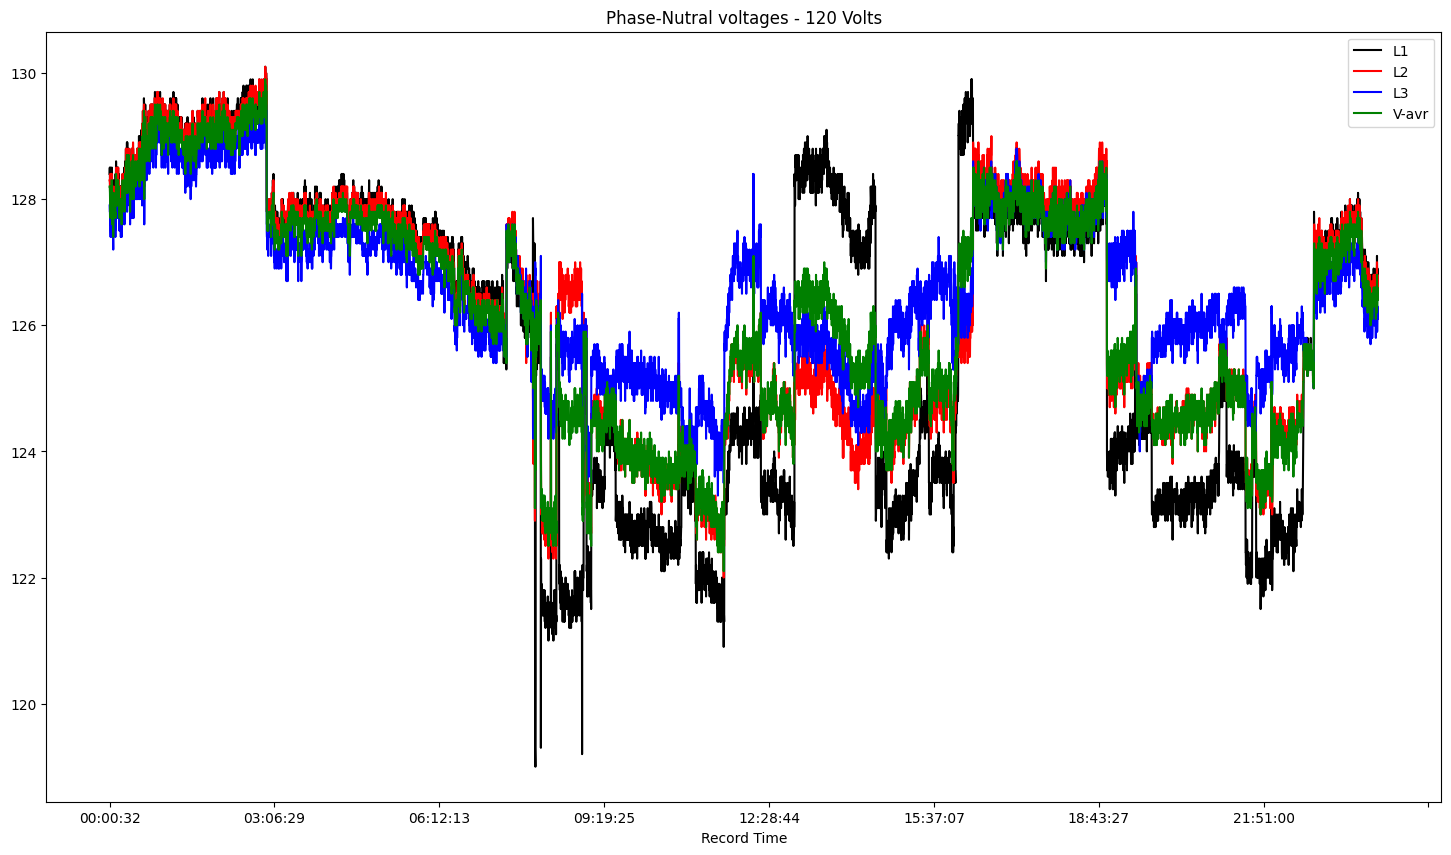

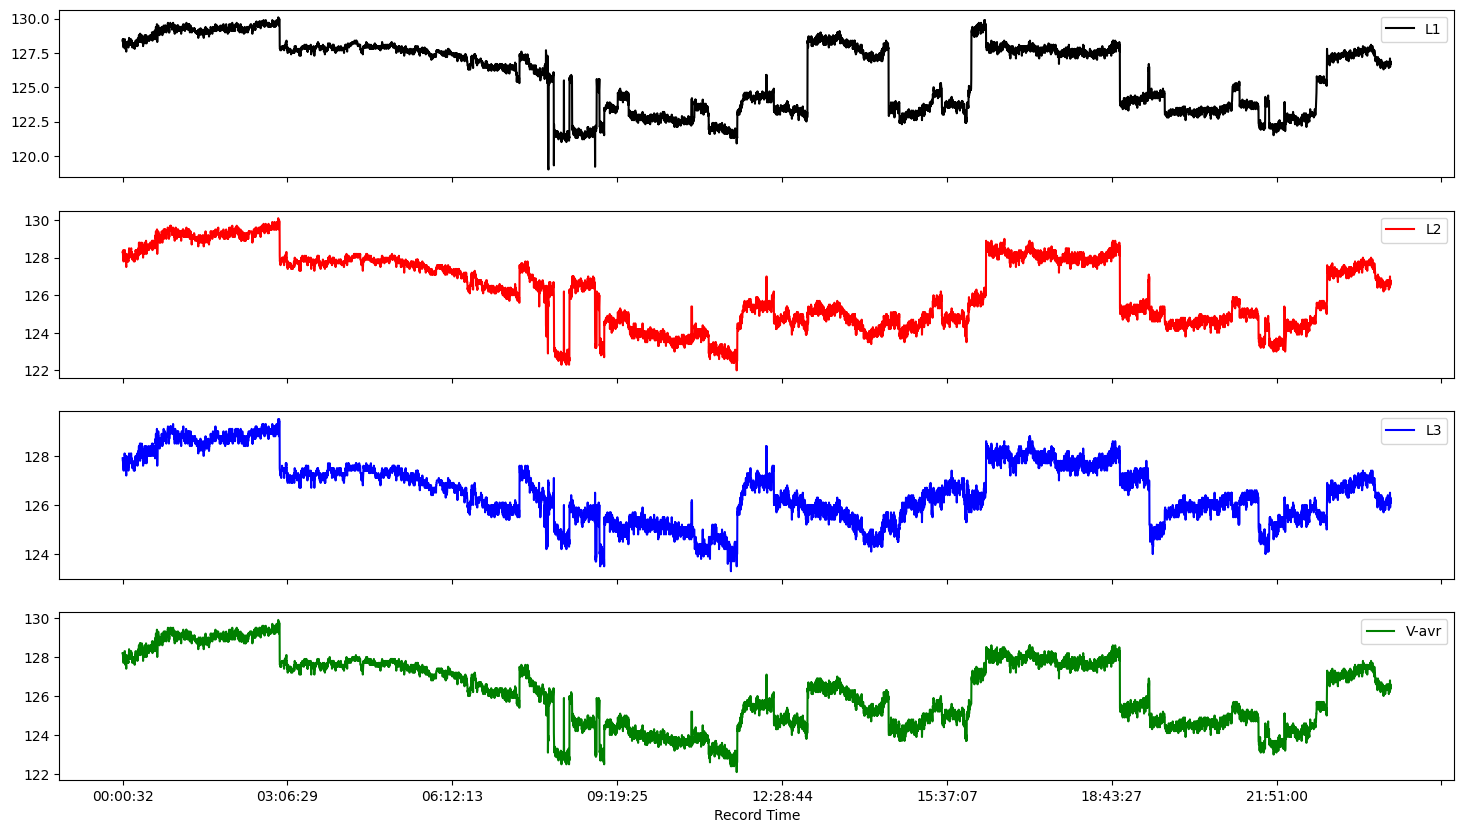

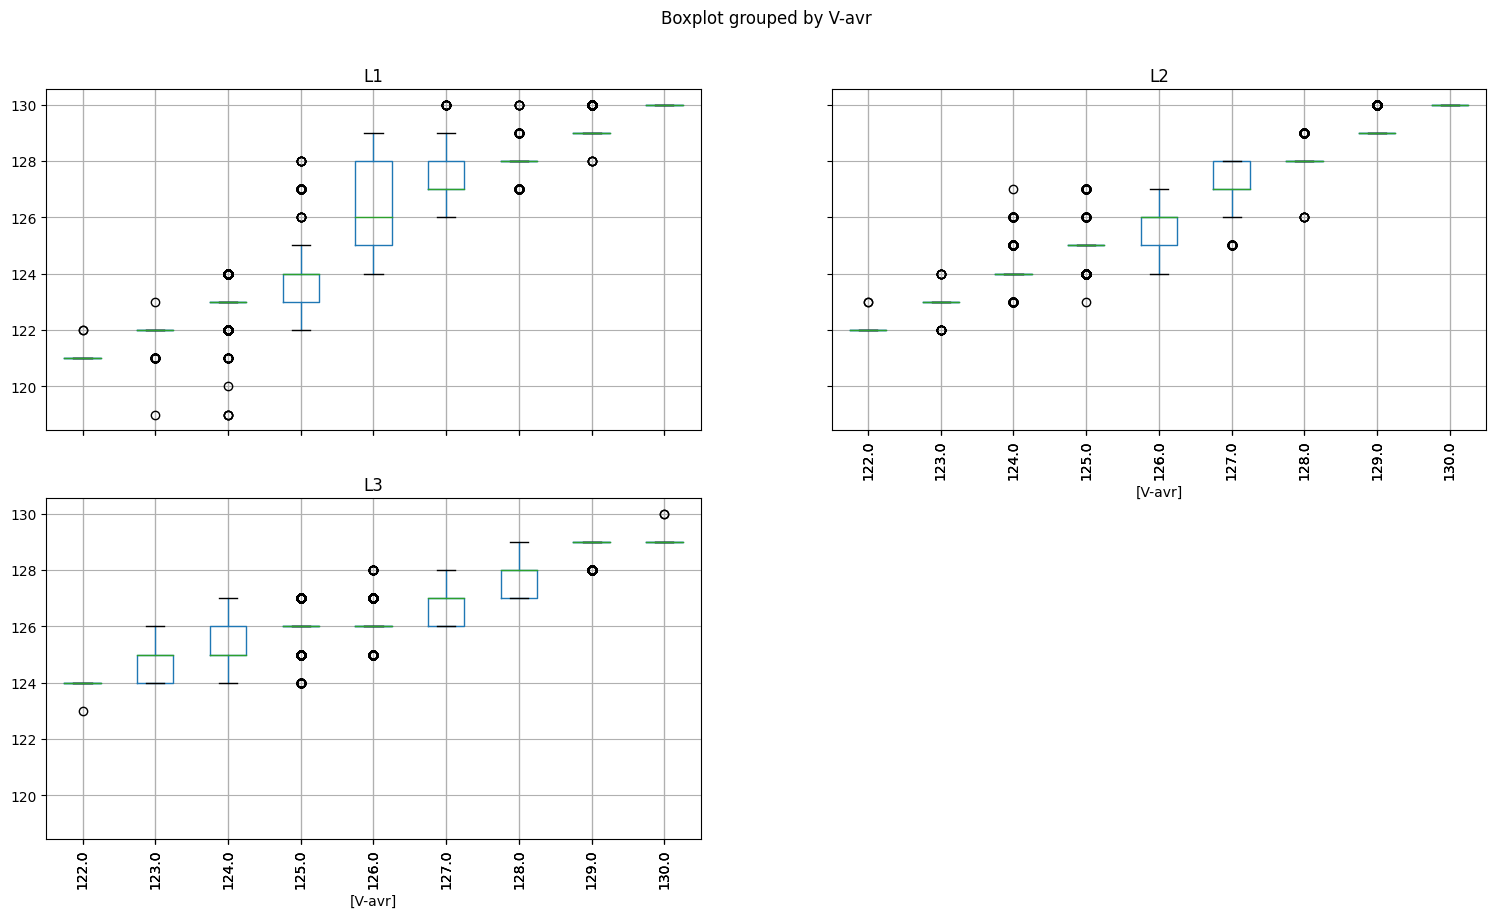

In [10]:
plot_data('v120','line')
new['v120'].plot.line(x='Record Time' , subplots=True, color=color['v120'], figsize=(18, 10))
vbox=new['v120'].round()
vbox.boxplot(column=['L1', 'L2', 'L3'], by=['V-avr'], figsize=(18, 10), rot=90, fontsize=10)

# Phase-Phase voltages - 208 Volts
This is normally tested with a multi meter by touching the prods into the testing port of the distro to mesure voltage, one prod on the phases you want to mesure .  The maximum "safe" voltage should be around 226 Volts, the minimum is around 198-200 Volts, it should be 208 Volts, but was normaly 218 Volts.


log file column: 
- L12
- L23
- L31

# Average Phase-Phase voltage

Average Phase-Phase voltage of all 3 groupings of L12, L23, L31

log file column: 
- U-avr

In [11]:
max_volts2=226.0
base_volts2=208.0
min_volts2=200.0

get_ptype.append('v208')
color['v208'] = {"L12": "black", "L23": "red", "L31": "blue", "U-avr": "green"}
title['v208']="Phase-Phase voltages - 208 Volts"

new['v208'] = pd.concat([df['Record Time'], df['L12'], df['L23'], df['L31'], df['U-avr']], axis=1)
new['v208']


,Record Time,L12,L23,L31,U-avr
0,00:00:32,222.4,221.9,221.8,222.0
1,00:00:43,222.5,222.0,221.8,222.1
2,00:00:54,222.2,221.8,221.6,221.8
3,00:01:06,222.0,221.6,221.3,221.6
4,00:01:17,222.5,222.1,221.8,222.1
...,...,...,...,...,...
7689,23:59:09,219.3,218.6,218.5,218.8
7690,23:59:20,219.7,219.0,219.0,219.2
7691,23:59:31,219.8,219.2,219.1,219.3
7692,23:59:42,219.6,219.0,218.8,219.1


array([[<AxesSubplot: title={'center': 'L12'}, xlabel='[U-avr]'>,
        <AxesSubplot: title={'center': 'L23'}, xlabel='[U-avr]'>],
       [<AxesSubplot: title={'center': 'L31'}, xlabel='[U-avr]'>,
        <AxesSubplot: >]], dtype=object)

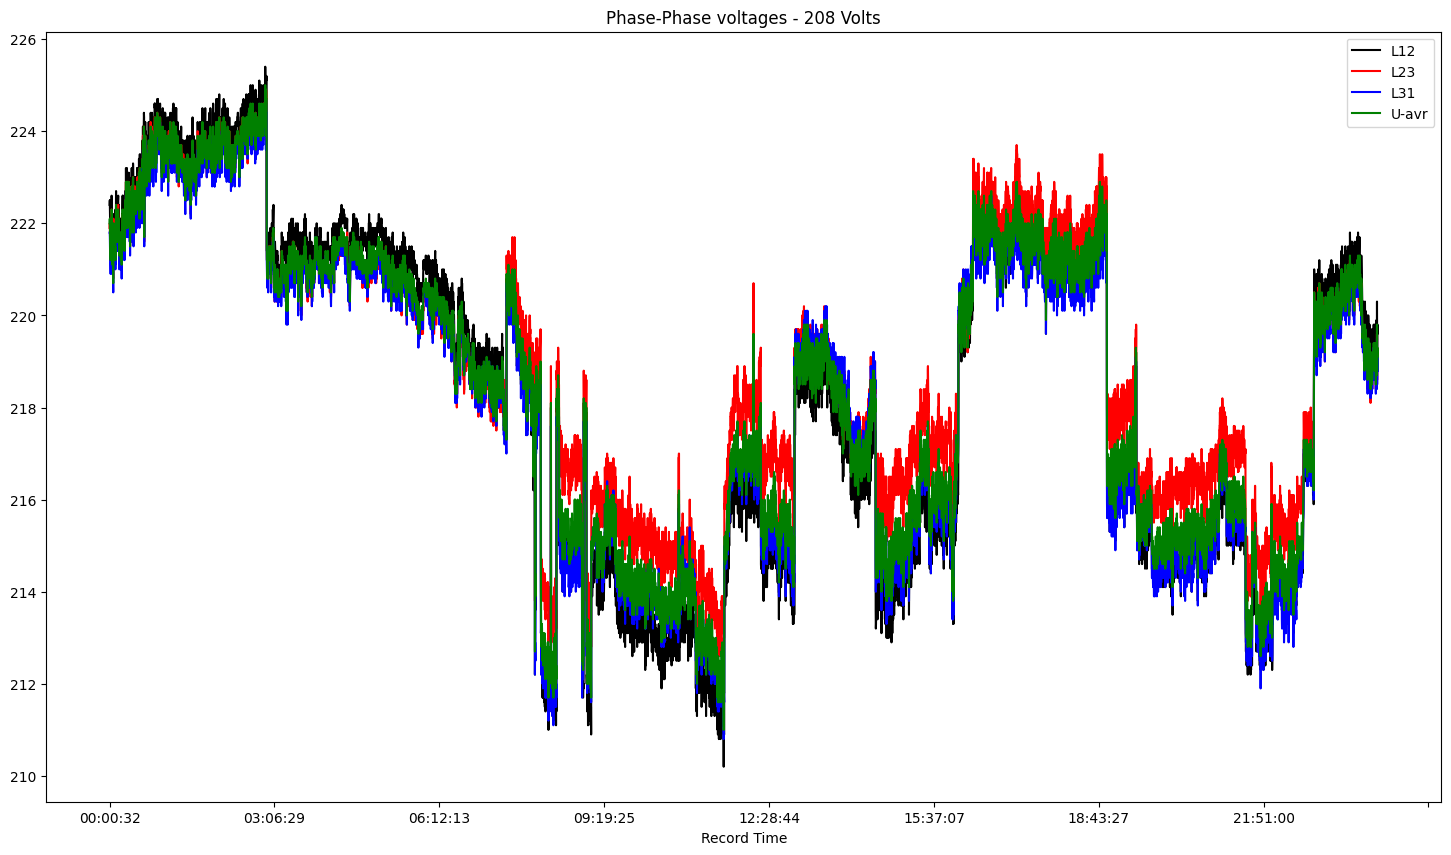

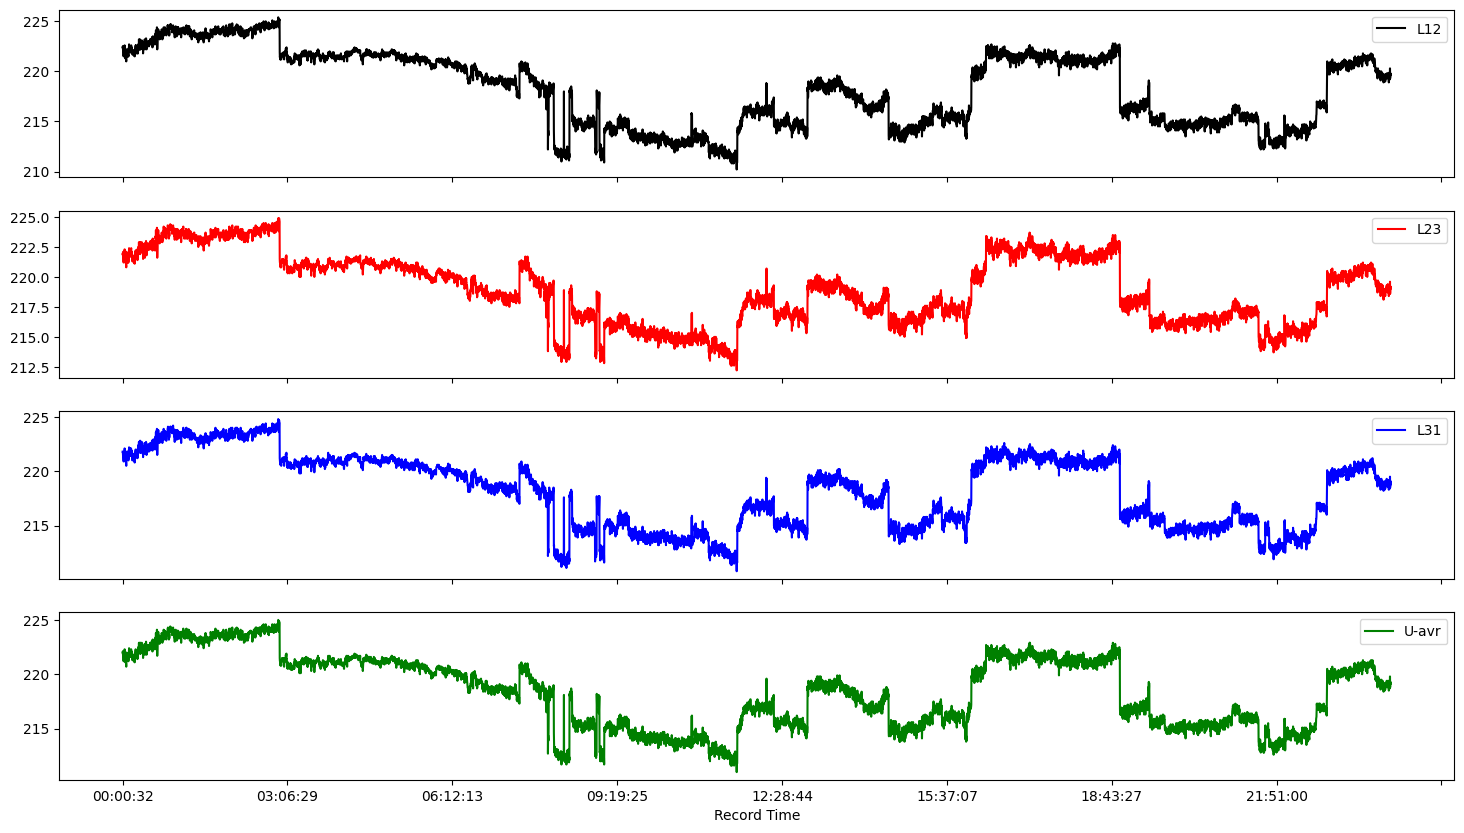

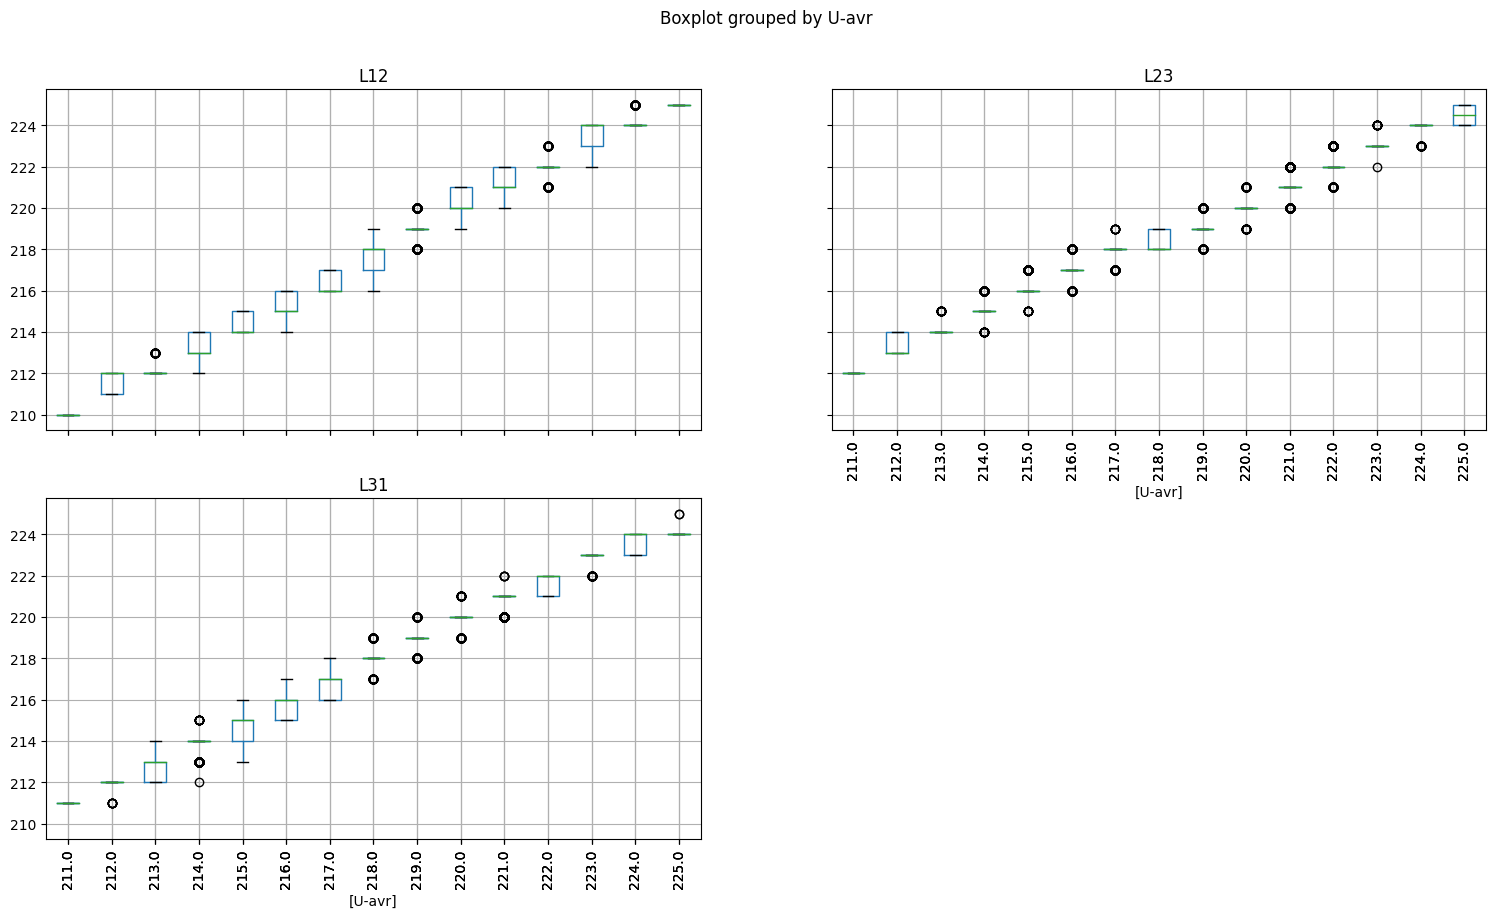

In [12]:
plot_data('v208','line')
new['v208'].plot.line(x='Record Time' , subplots=True, color=color['v208'], figsize=(18, 10))
box = new['v208'].round()
box.boxplot(column=['L12', 'L23', 'L31'], by=['U-avr'], figsize=(18, 10), rot=90, fontsize=10)

# Phase currents

log file column: 
- I1
- I2
- I3
- In

# Average current

log file column: 
- I-avr

In [13]:
get_ptype.append('amps')
color['amps'] = {"I1": "black", "I2": "red", "I3": "blue", "In": 'yellow', 'I-avr': "green"}
title['amps']="Phase currents "

new['amps'] = pd.concat([df['Record Time'], df['I1'], df['I2'], df['I3'], df['In'], df['I-avr']], axis=1 )
new['amps']


,Record Time,I1,I2,I3,In,I-avr
0,00:00:32,0.0,0.0,0.0,0.0,0.0
1,00:00:43,0.0,0.0,0.0,0.0,0.0
2,00:00:54,0.0,0.0,0.0,0.0,0.0
3,00:01:06,0.0,0.0,0.0,0.0,0.0
4,00:01:17,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
7689,23:59:09,0.0,0.0,0.0,0.0,0.0
7690,23:59:20,0.0,0.0,0.0,0.0,0.0
7691,23:59:31,0.0,0.0,0.0,0.0,0.0
7692,23:59:42,0.0,0.0,0.0,0.0,0.0


array([[<AxesSubplot: title={'center': 'I1'}, xlabel='[I-avr]'>,
        <AxesSubplot: title={'center': 'I2'}, xlabel='[I-avr]'>],
       [<AxesSubplot: title={'center': 'I3'}, xlabel='[I-avr]'>,
        <AxesSubplot: title={'center': 'In'}, xlabel='[I-avr]'>]],
      dtype=object)

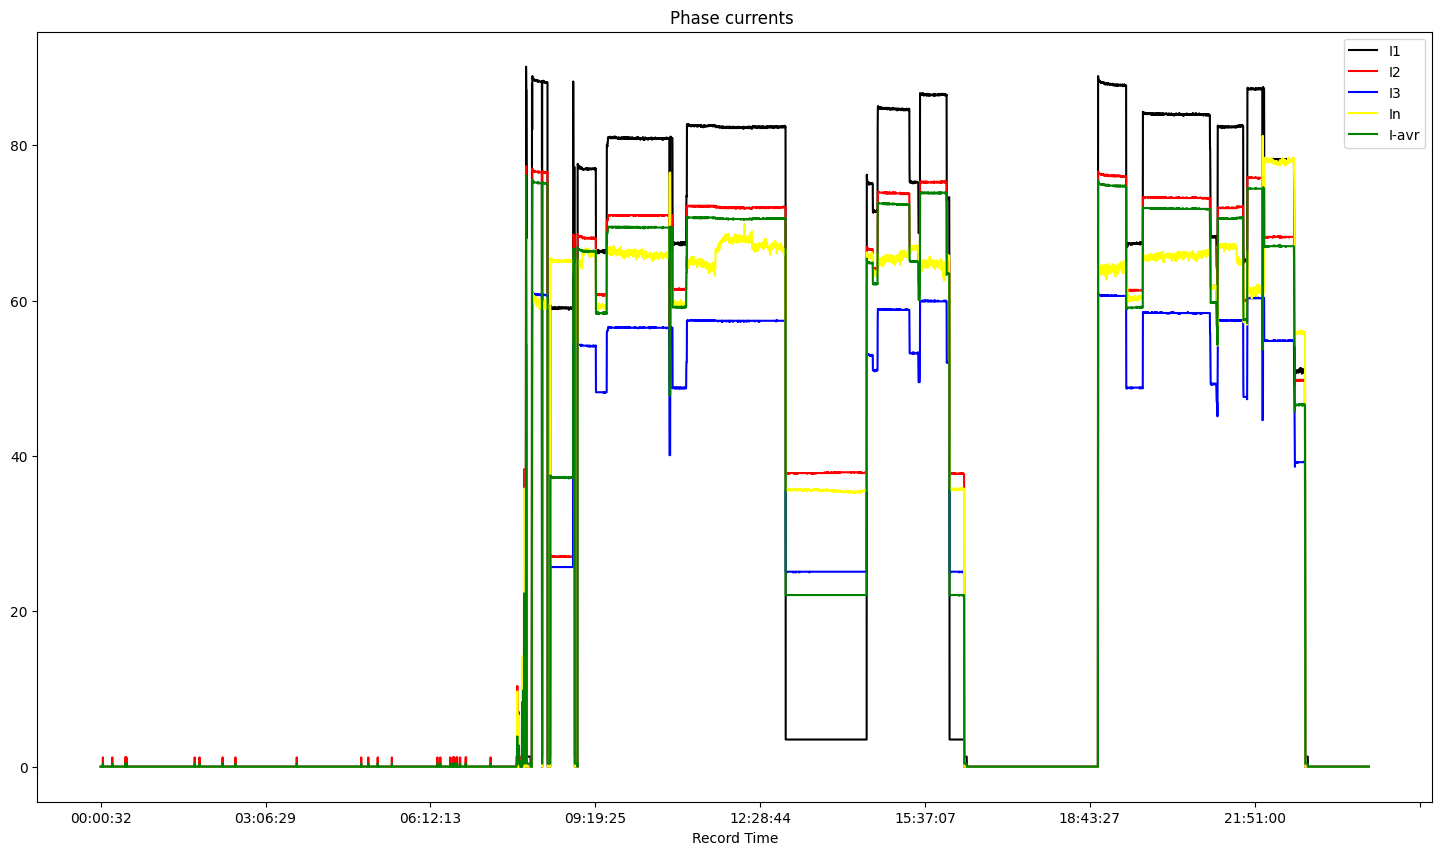

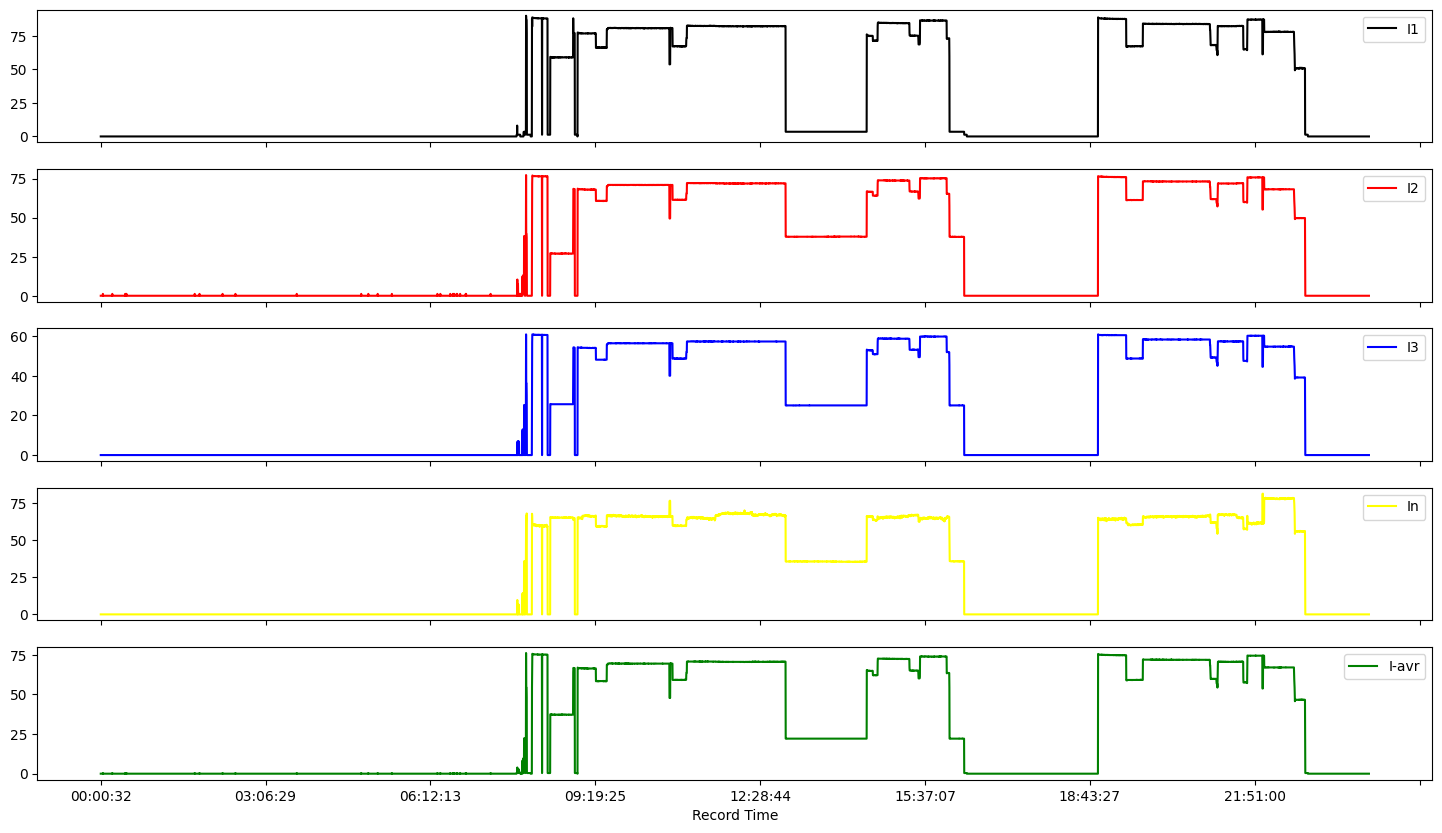

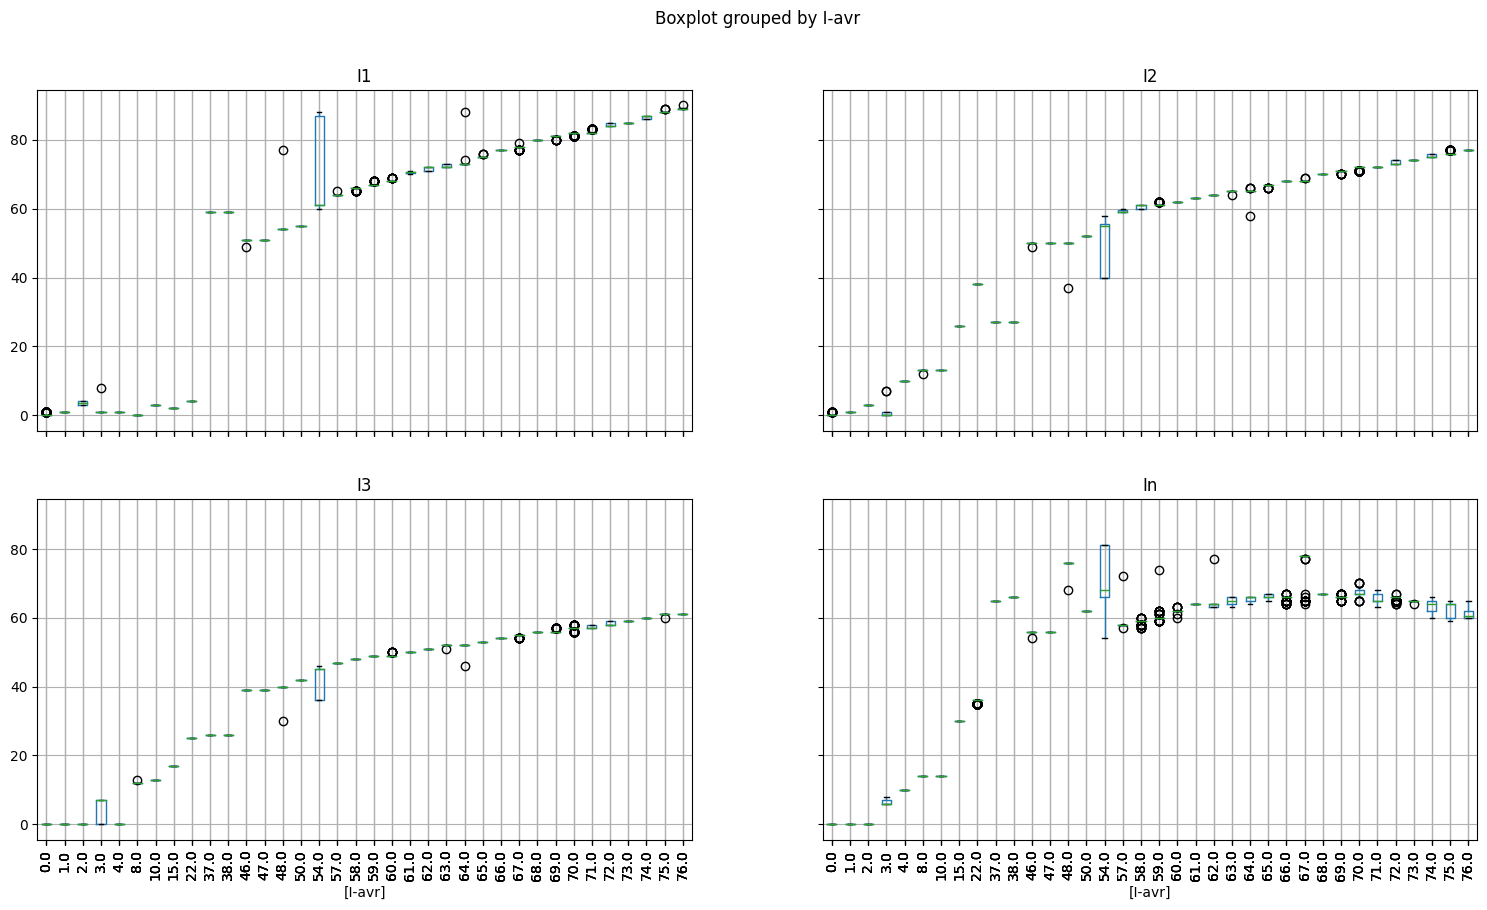

In [14]:
plot_data('amps','line')
new['amps'].plot.line(x='Record Time' , subplots=True, color=color['amps'], figsize=(18, 10))
abox = new['amps'].round()
abox.boxplot(column=['I1', 'I2', 'I3', 'In'], by=['I-avr'], figsize=(18, 10), rot=90, fontsize=10)

# Demands: Phase Currents 
dI1 dI2, dI3, dIo as Amps

log file column: 
- dI1
- dI2
- dI3
- dIo

In [15]:
get_ptype.append('damps')
color['damps'] = {"dI1": "black", "dI2": "red", "dI3": "blue", "dIo": 'green'}
title['damps']="Demand Phase currents "

new['damps'] = pd.concat([df['Record Time'], df['dI1'], df['dI2'], df['dI3'], df['dIo']], axis=1)
new['damps']

,Record Time,dI1,dI2,dI3,dIo
0,00:00:32,96.7,70.6,53.2,73.4
1,00:00:43,96.7,70.6,53.2,73.4
2,00:00:54,96.7,70.6,53.2,73.4
3,00:01:06,96.7,70.6,53.2,73.4
4,00:01:17,96.7,70.6,53.2,73.4
...,...,...,...,...,...
7689,23:59:09,96.7,76.0,60.6,74.7
7690,23:59:20,96.7,76.0,60.6,74.7
7691,23:59:31,96.7,76.0,60.6,74.7
7692,23:59:42,96.7,76.0,60.6,74.7


array([<AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>], dtype=object)

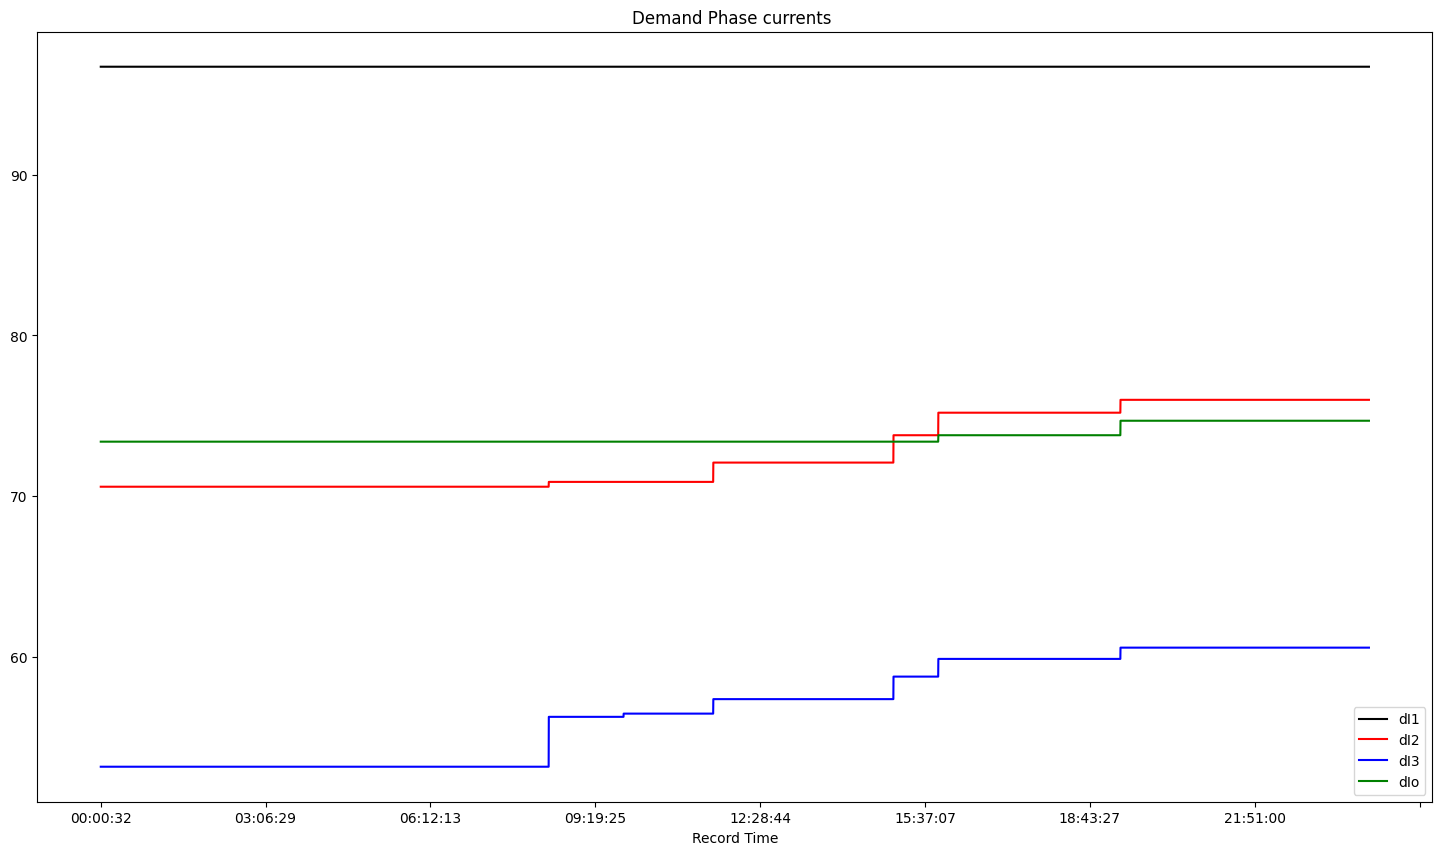

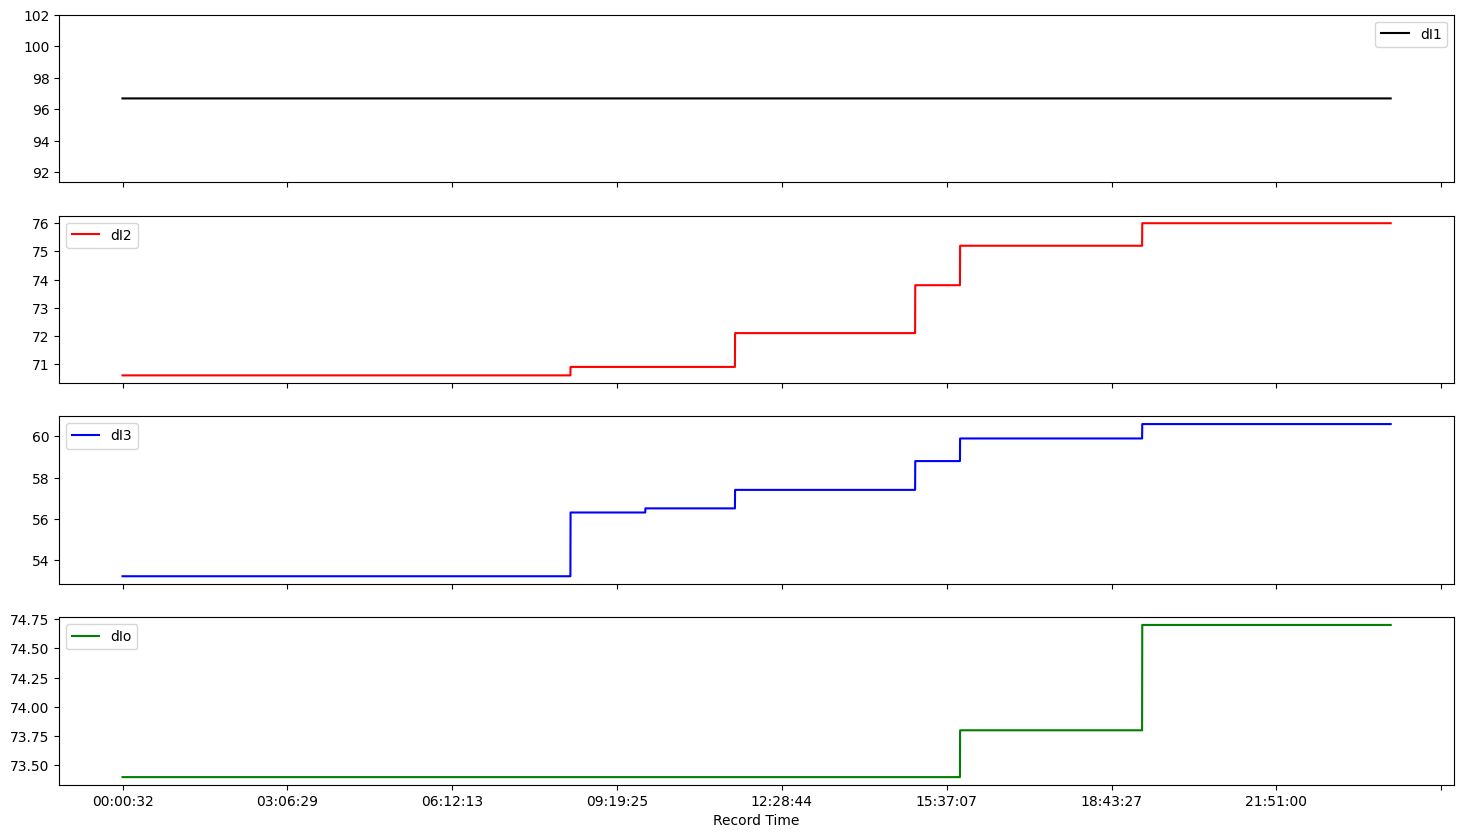

In [16]:
plot_data('damps','line')
new['damps'].plot.line(x='Record Time' , subplots=True, color=color['damps'], figsize=(18, 10))

# Freqency
Freq, logged as Hz
 
log file column: 
- Freq.

In [17]:
get_ptype.append('Freqency')
color['Freqency'] = {"Freq.": "black"}
title['Freqency']="Freqency"

new['Freqency'] = pd.concat([df['Record Time'], df['Freq.']], axis=1)
new['Freqency']

,Record Time,Freq.
0,00:00:32,60.00
1,00:00:43,60.01
2,00:00:54,60.01
3,00:01:06,60.01
4,00:01:17,60.01
...,...,...
7689,23:59:09,59.97
7690,23:59:20,59.96
7691,23:59:31,59.96
7692,23:59:42,59.96


<AxesSubplot: title={'center': 'Freqency'}, xlabel='Record Time'>

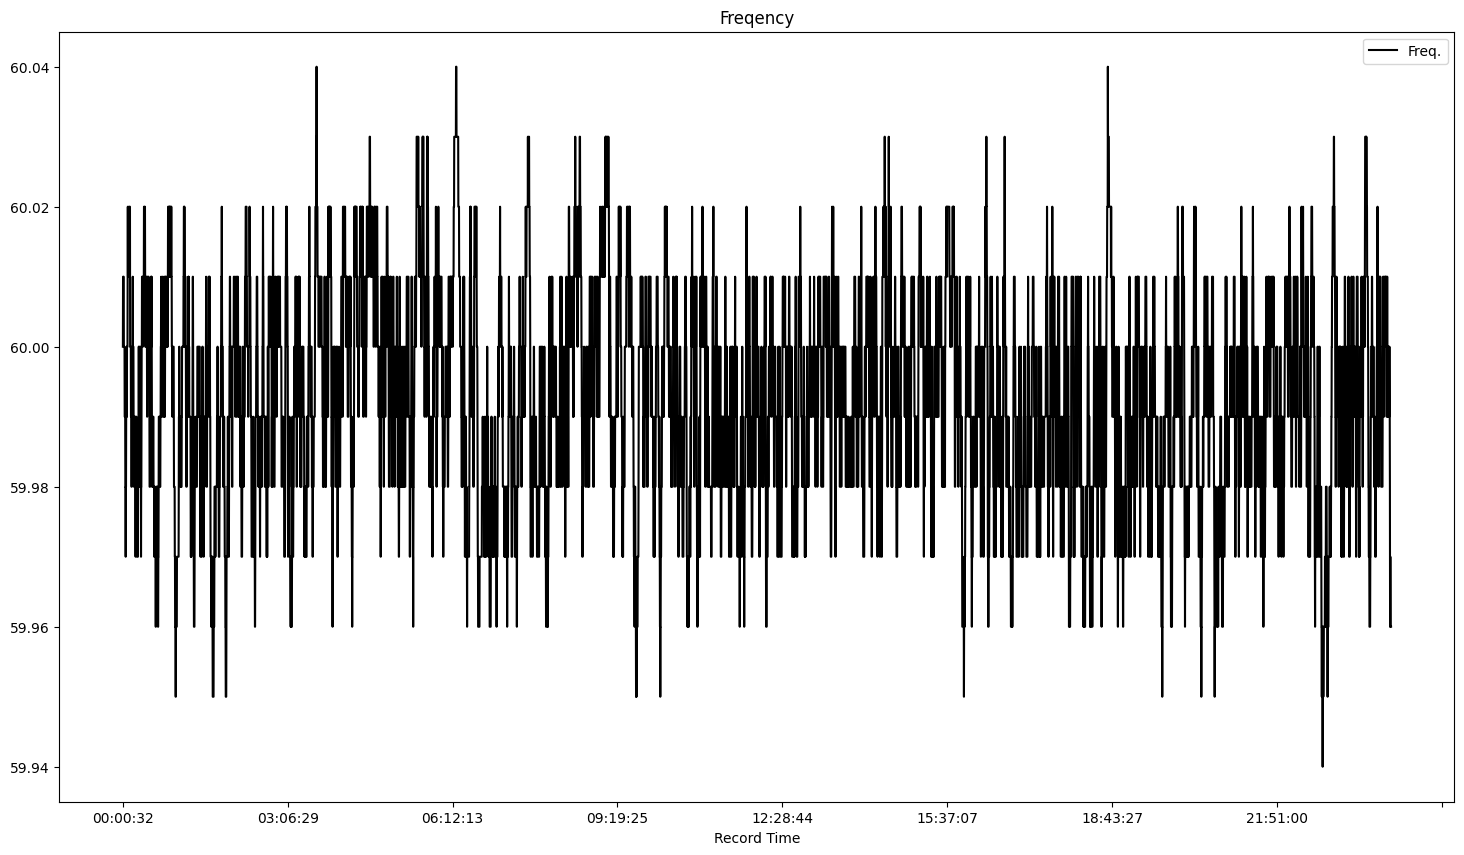

In [18]:
plot_data('Freqency','line')


# Total power factor (pf)
log file column: 
- PF

In [19]:
get_ptype.append("PF")
color['PF'] = {"PF": "black"}
title['PF']="Total power factor (pf)"

new['PF'] = pd.concat([df['Record Time'], df['PF']], axis=1)
new['PF']    



,Record Time,PF
0,00:00:32,0.0
1,00:00:43,0.0
2,00:00:54,0.0
3,00:01:06,0.0
4,00:01:17,0.0
...,...,...
7689,23:59:09,0.0
7690,23:59:20,0.0
7691,23:59:31,0.0
7692,23:59:42,0.0


<AxesSubplot: title={'center': 'Total power factor (pf)'}, xlabel='Record Time'>

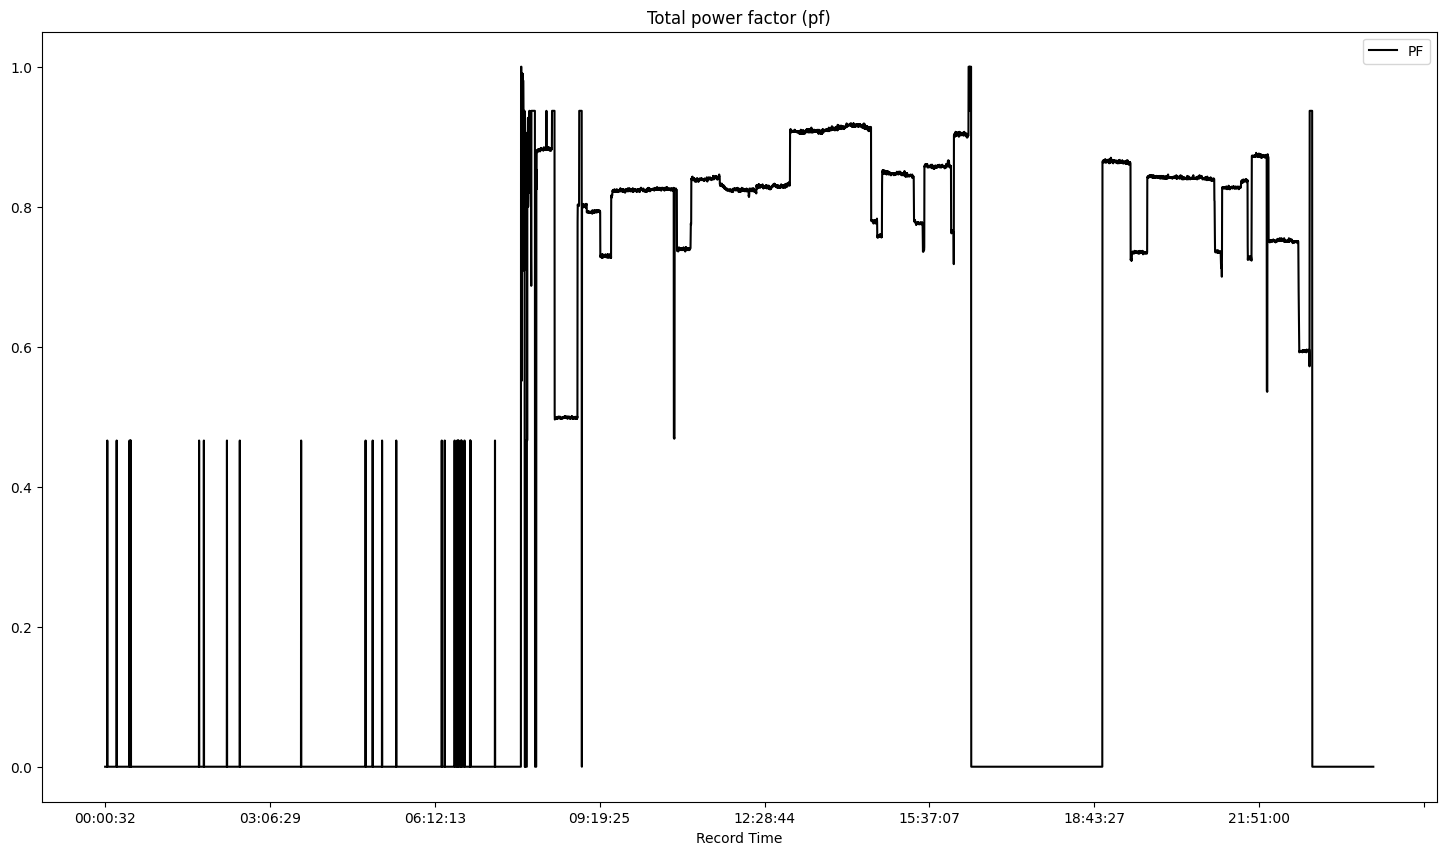

In [20]:
plot_data('PF','line')

# Active Power (kW)

P, P1, P2, P3 is Active power or real power, logged in Kilo-Watts kW

log file column: 
- P
- P1
- P2
- P3 

## Demands: Active Power 

log file column: 
- dkW

In [21]:
get_ptype.append("P")
color['P'] = {"P": "pink", "P1": "black", "P2": "red", "P3": "blue"}
title['P']="Total Active Power (kW)"

new['P'] = pd.concat([df['Record Time'], df['P'], df['P1'], df['P2'], df['P3']], axis=1)
new['P']


,Record Time,P,P1,P2,P3
0,00:00:32,0.0,0.0,0.0,0.0
1,00:00:43,0.0,0.0,0.0,0.0
2,00:00:54,0.0,0.0,0.0,0.0
3,00:01:06,0.0,0.0,0.0,0.0
4,00:01:17,0.0,0.0,0.0,0.0
...,...,...,...,...,...
7689,23:59:09,0.0,0.0,0.0,0.0
7690,23:59:20,0.0,0.0,0.0,0.0
7691,23:59:31,0.0,0.0,0.0,0.0
7692,23:59:42,0.0,0.0,0.0,0.0


array([<AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>], dtype=object)

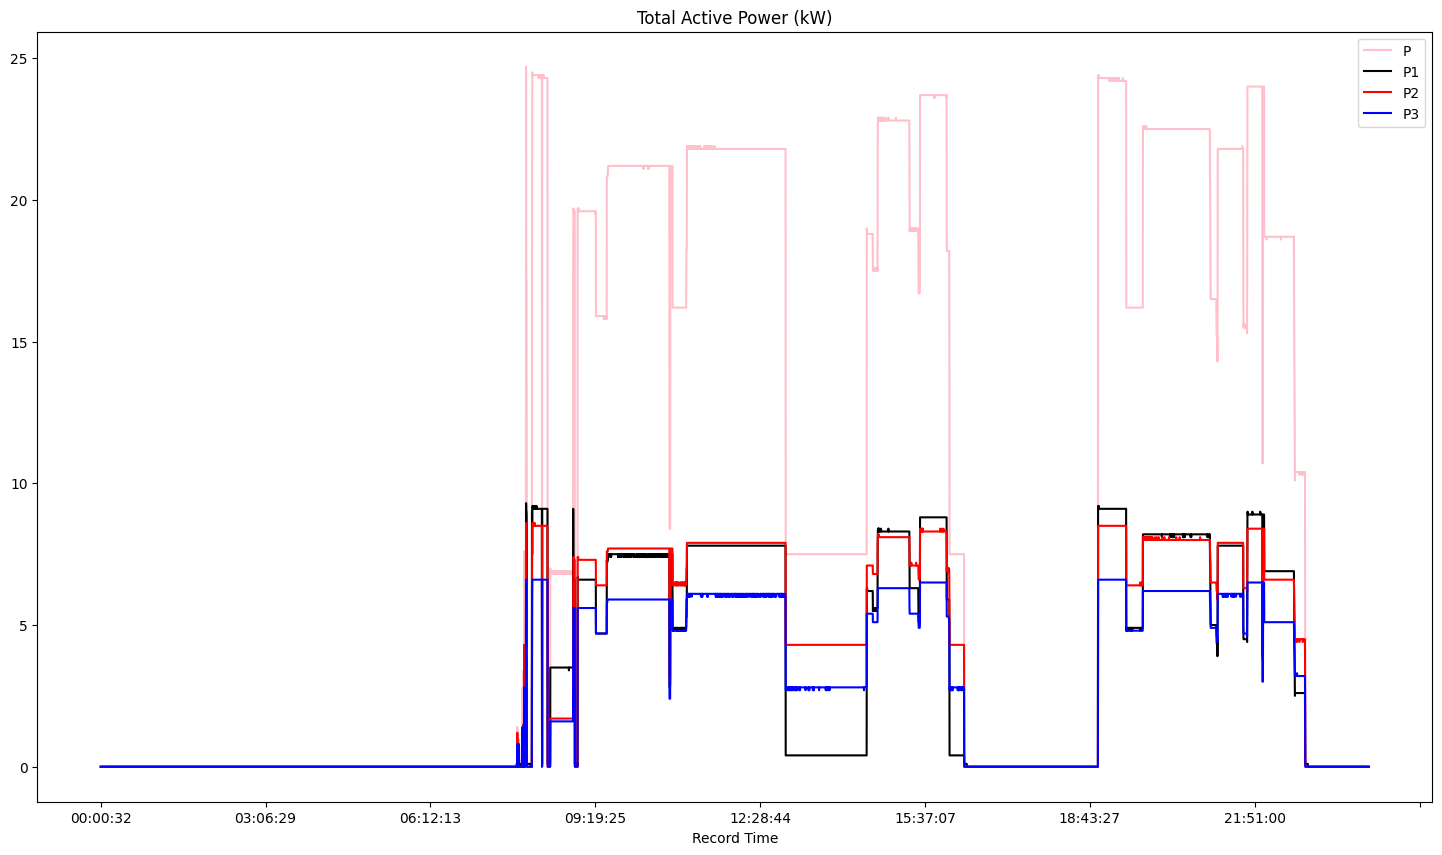

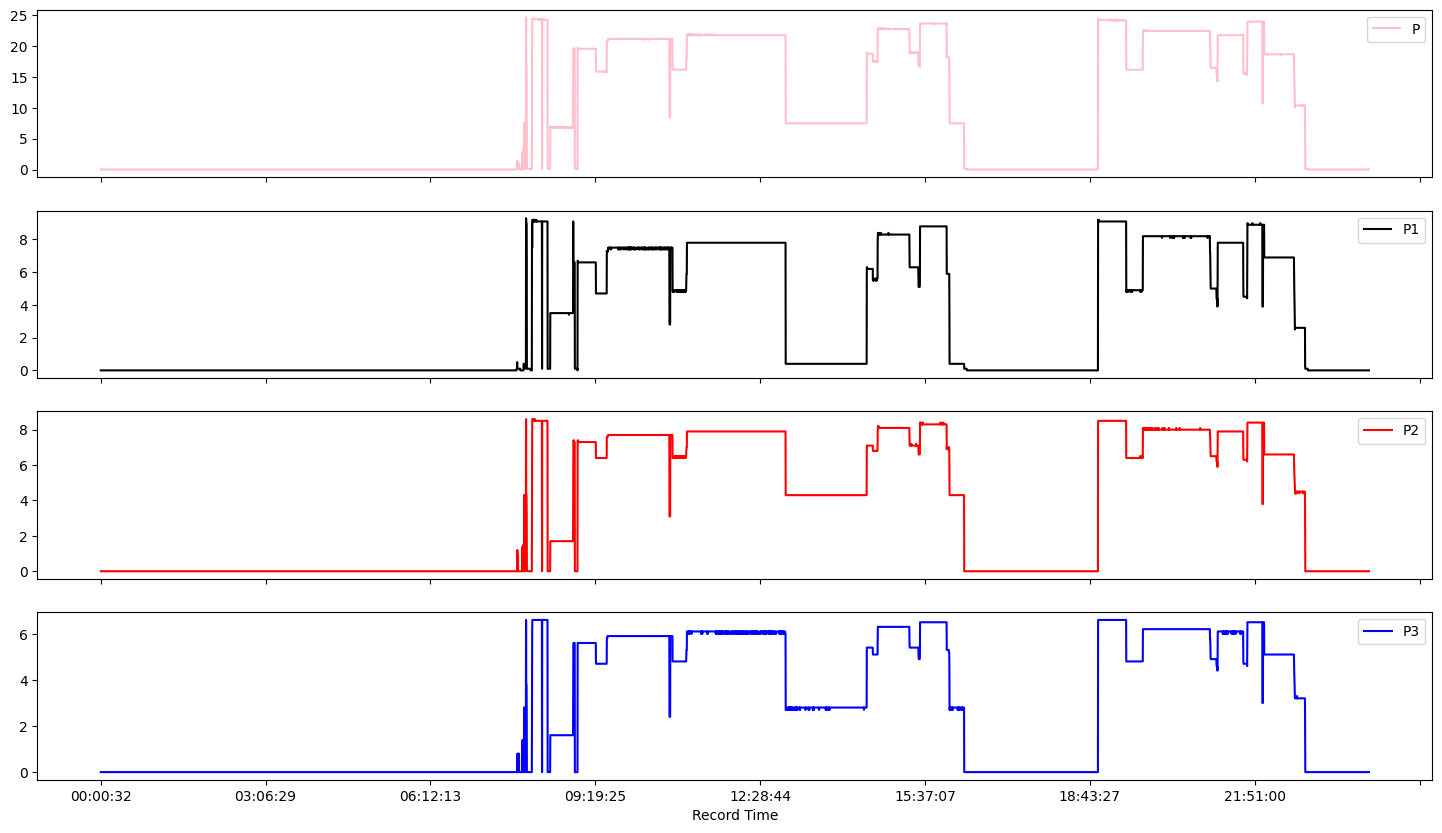

In [22]:
plot_data('P','line')
new['P'].plot.line(x='Record Time' , subplots=True, color=color['P'], figsize=(18, 10))

In [23]:

get_ptype.append("dkW")
color['dkW'] = { "dkW": "black"}
title['dkW']="Demands: Active Power (kW)"

new['dkW'] = pd.concat([df['Record Time'],df['dkW']], axis=1)
new['dkW']


,Record Time,dkW
0,00:00:32,50.3
1,00:00:43,50.3
2,00:00:54,50.3
3,00:01:06,50.3
4,00:01:17,50.3
...,...,...
7689,23:59:09,50.3
7690,23:59:20,50.3
7691,23:59:31,50.3
7692,23:59:42,50.3


<AxesSubplot: title={'center': 'Demands: Active Power (kW)'}, xlabel='Record Time'>

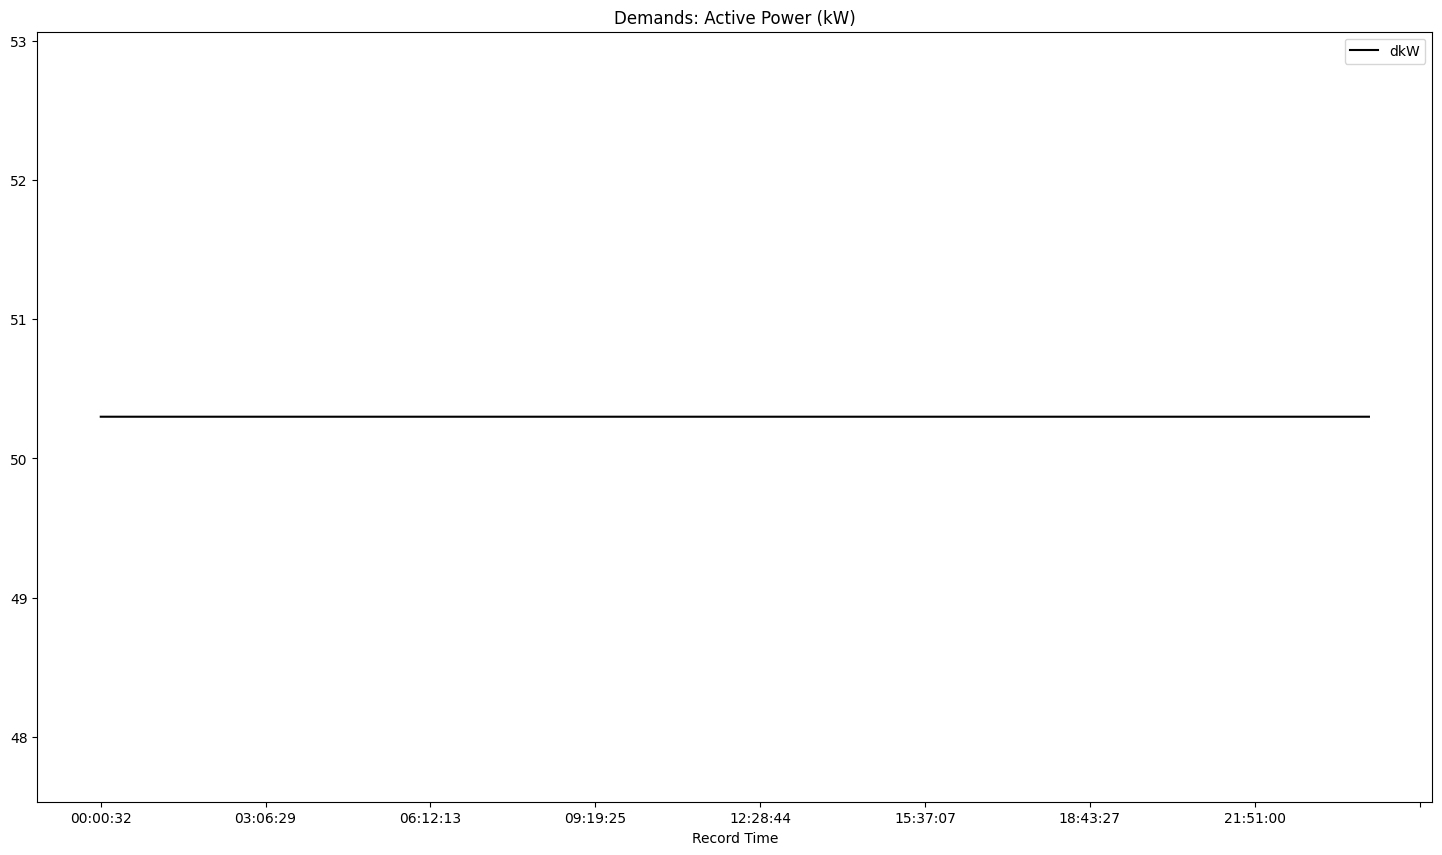

In [24]:
plot_data('dkW','line')


# Reactive power (kVAr)

Q, Q1, Q2, Q3 is Reactive power, logged as kVar

log file column: 
- Q
- Q1
- Q2
- Q3

## Demands: Reactive Power 
dkVAr as kVAr

log file column: 
- dkVAr

In [25]:
get_ptype.append("Q")
color['Q'] = {"Q": "pink", "Q1": "black", "Q2": "red", "Q3": "blue" }
title['Q']="Reactive Power (kVAr)"

new['Q'] = pd.concat([df['Record Time'], df['Q'], df['Q1'], df['Q2'], df['Q3']], axis=1)
new['Q']



,Record Time,Q,Q1,Q2,Q3
0,00:00:32,0.0,0.0,0.0,0.0
1,00:00:43,0.0,0.0,0.0,0.0
2,00:00:54,0.0,0.0,0.0,0.0
3,00:01:06,0.0,0.0,0.0,0.0
4,00:01:17,0.0,0.0,0.0,0.0
...,...,...,...,...,...
7689,23:59:09,0.0,0.0,0.0,0.0
7690,23:59:20,0.0,0.0,0.0,0.0
7691,23:59:31,0.0,0.0,0.0,0.0
7692,23:59:42,0.0,0.0,0.0,0.0


array([<AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>,
       <AxesSubplot: xlabel='Record Time'>], dtype=object)

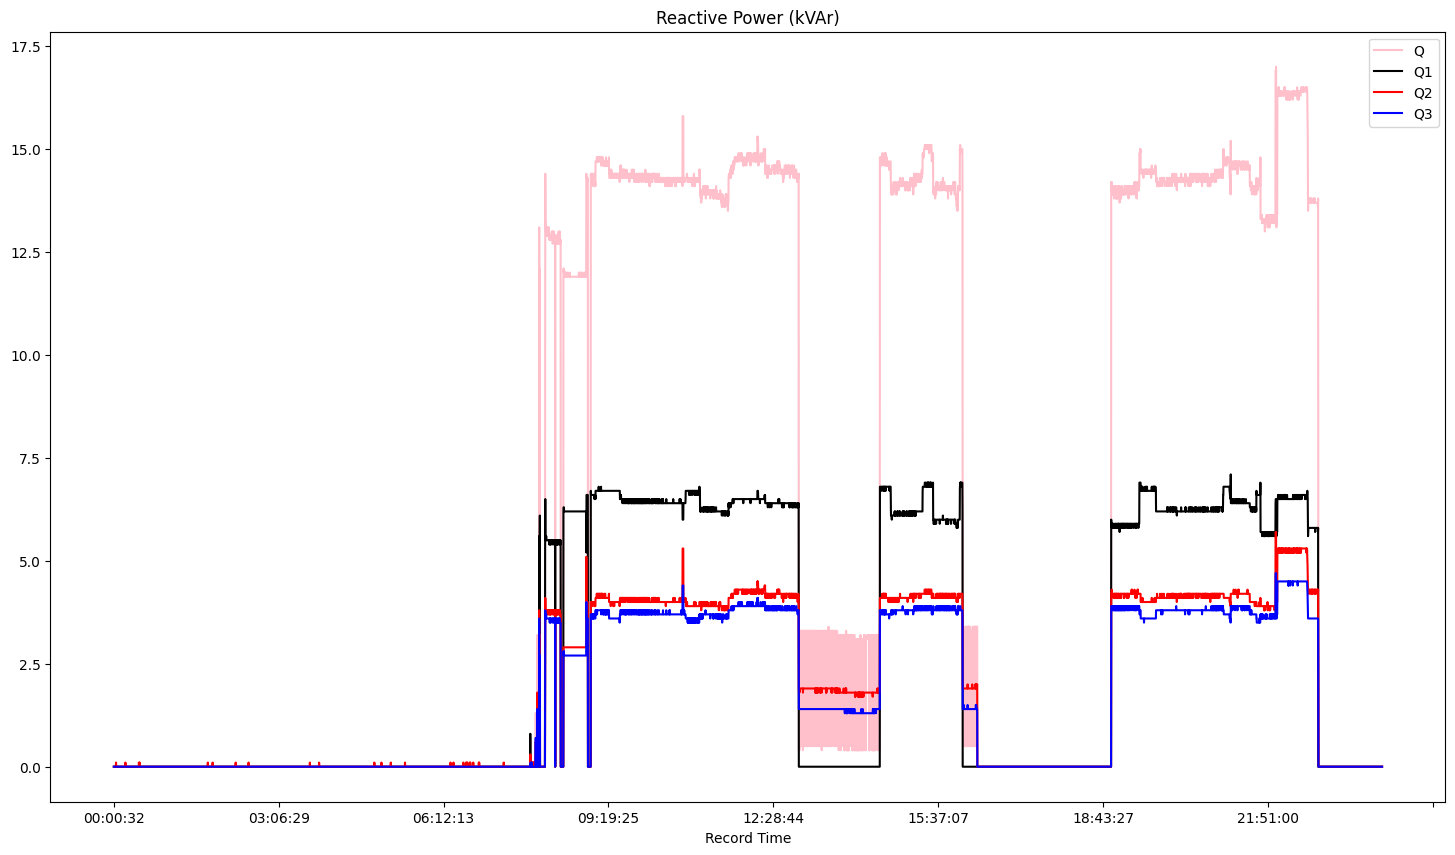

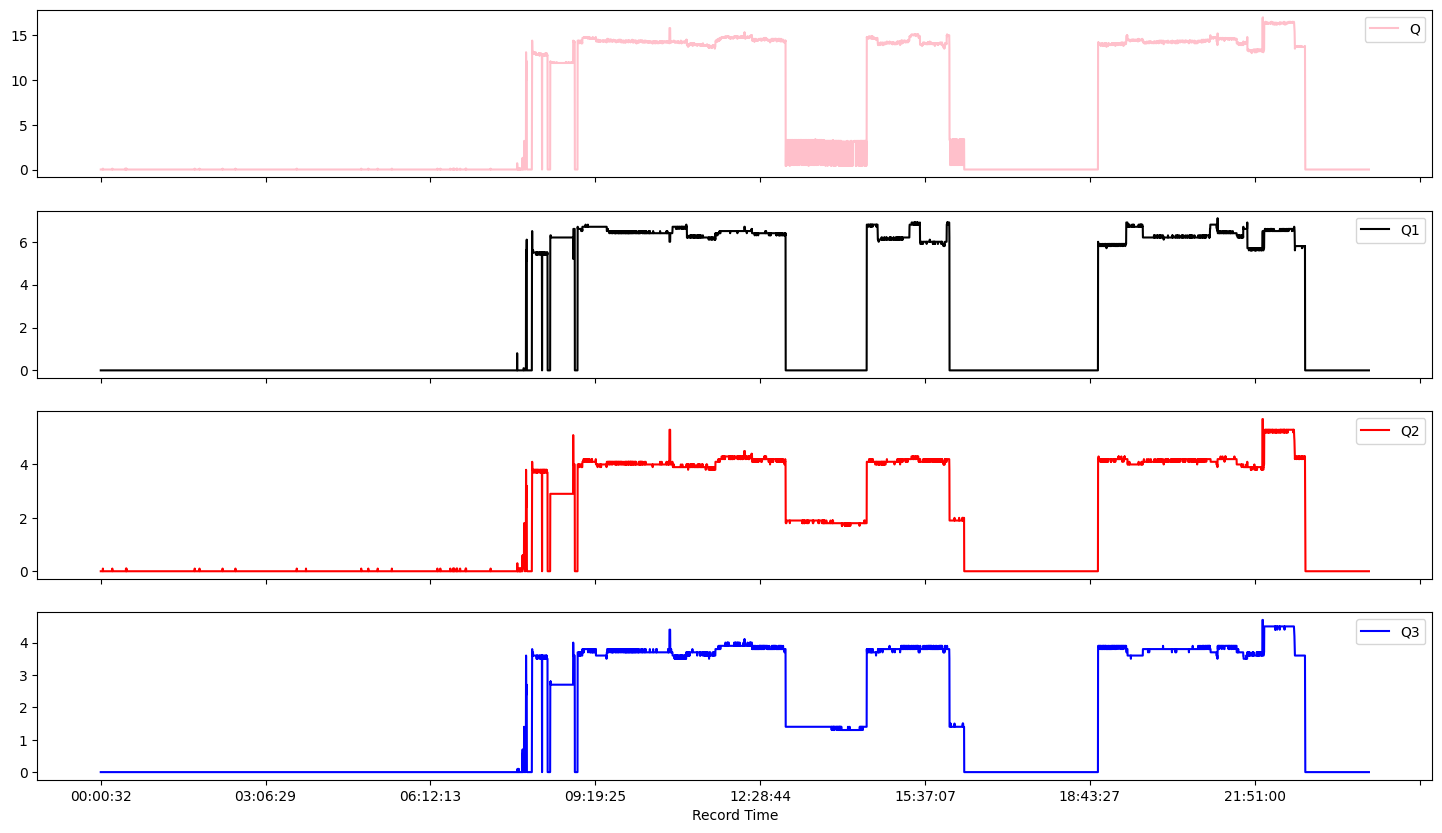

In [26]:
plot_data('Q','line')
new['Q'].plot.line(x='Record Time' , subplots=True, color=color['Q'], figsize=(18, 10))

In [27]:
get_ptype.append("dkVAr")
color['dkVAr'] = { "dkVAr": 'black'}
title['dkVAr']="Demands: Reactive Power (kVAr)"

new['dkVAr'] = pd.concat([df['Record Time'], df['dkVAr']], axis=1)
new['dkVAr']

,Record Time,dkVAr
0,00:00:32,16.8
1,00:00:43,16.8
2,00:00:54,16.8
3,00:01:06,16.8
4,00:01:17,16.8
...,...,...
7689,23:59:09,32.7
7690,23:59:20,32.7
7691,23:59:31,32.7
7692,23:59:42,32.7


<AxesSubplot: title={'center': 'Demands: Reactive Power (kVAr)'}, xlabel='Record Time'>

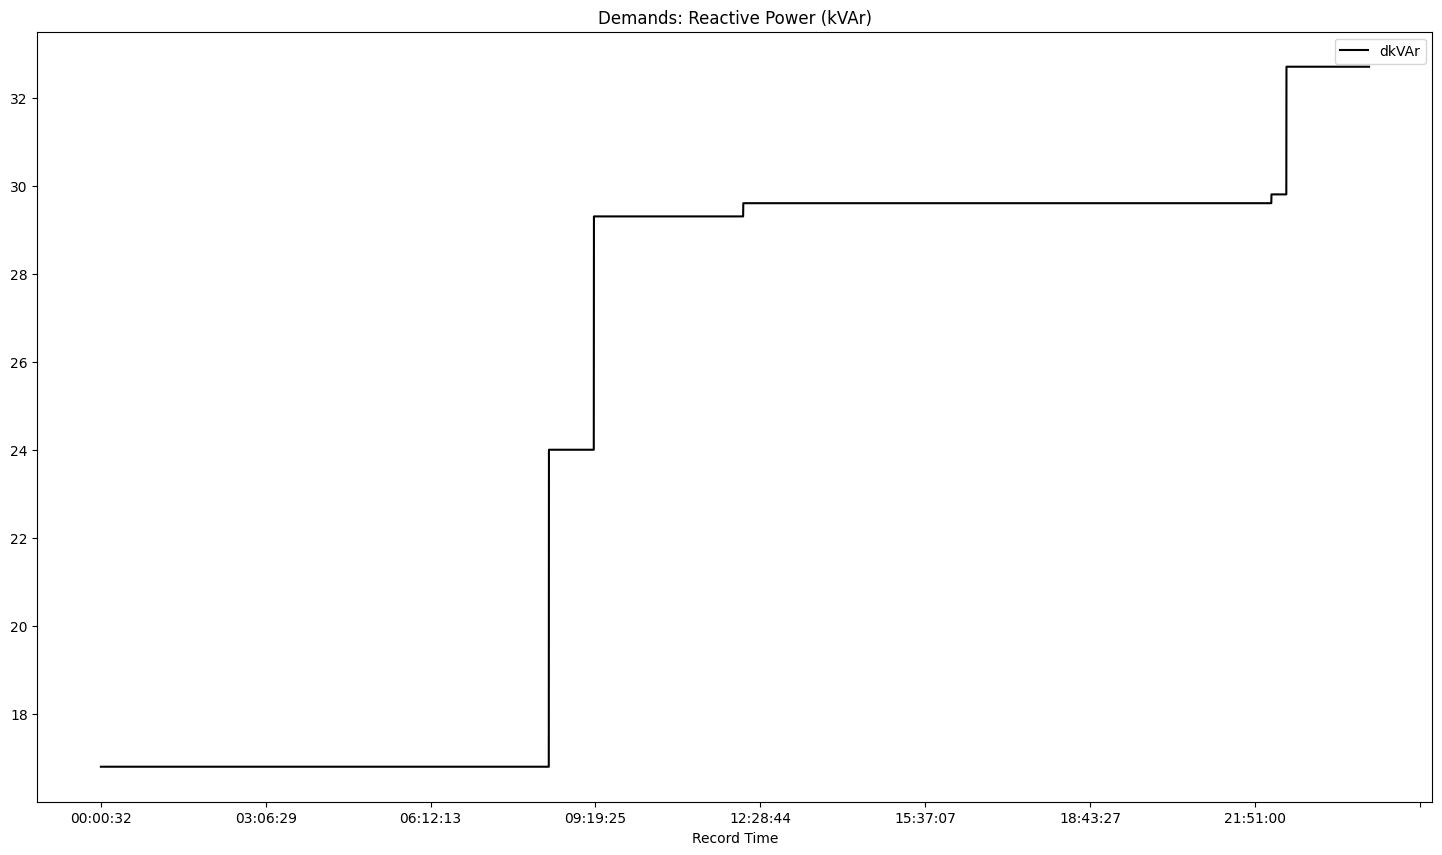

In [28]:
plot_data('dkVAr','line')

# Apparent power (kVA)

S is Complex power, logged as kVA

log file column: 
- S

In [29]:
get_ptype.append("S")
color['S'] = {"S": "black"}
title['S']="Apparent/Complex Power (kVA)"

new['S'] = pd.concat([df['Record Time'], df['S']], axis=1)
new['S']

,Record Time,S
0,00:00:32,0.0
1,00:00:43,0.0
2,00:00:54,0.0
3,00:01:06,0.0
4,00:01:17,0.0
...,...,...
7689,23:59:09,0.0
7690,23:59:20,0.0
7691,23:59:31,0.0
7692,23:59:42,0.0


<AxesSubplot: title={'center': 'Apparent/Complex Power (kVA)'}, xlabel='Record Time'>

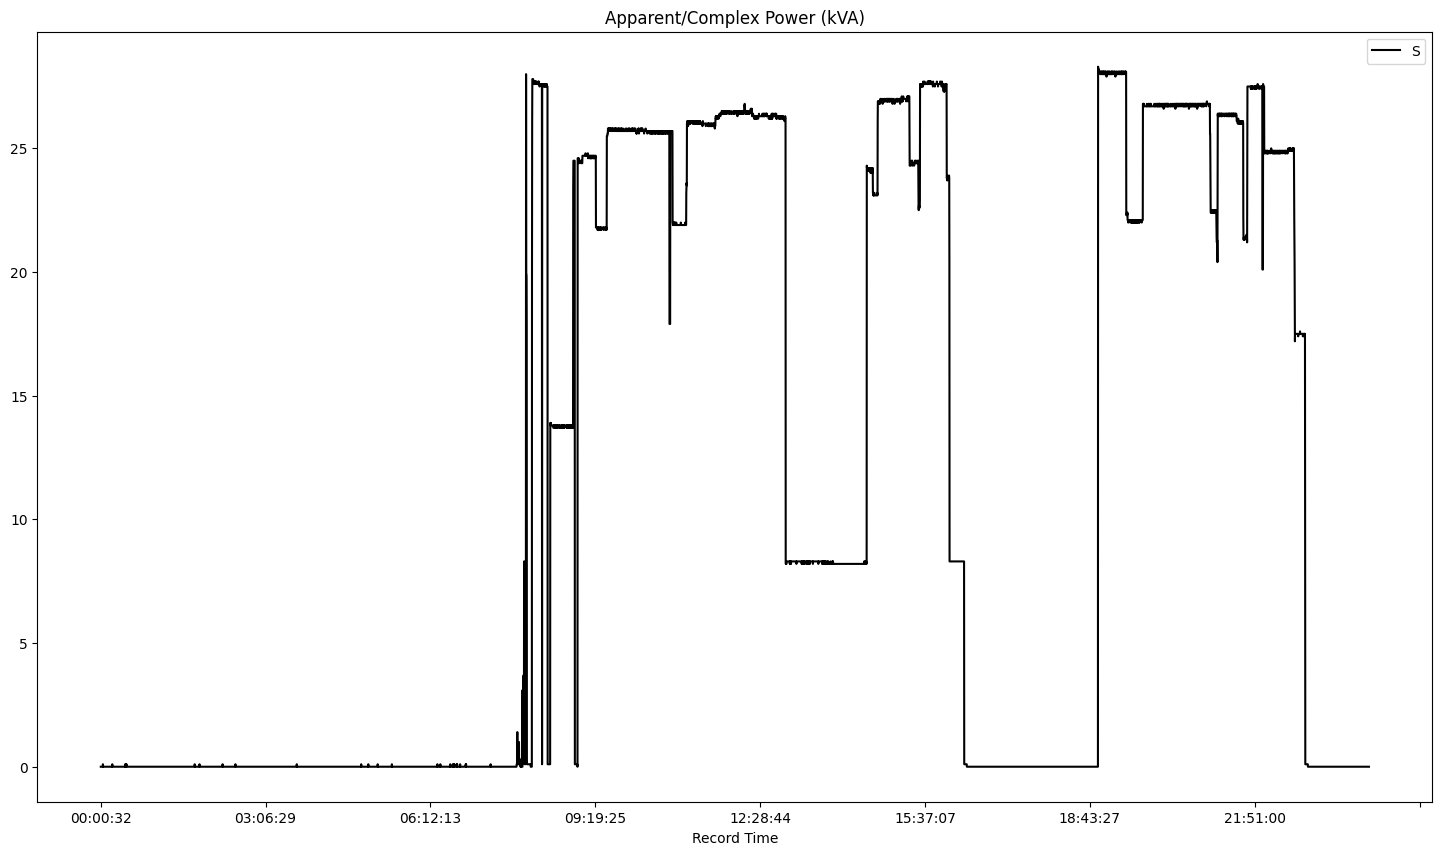

In [30]:
plot_data('S','line')


# Total harmonic distortion:
The Total Harmonic Distortion (THD) mode displays the following:

- THD per phase to Nutral for L1, L2, L3
- THD per phase to phase for L12, L23, L31
- THD current per phase for I1, I2, I3
- THD neutral current for In

log file column: 
- THD L1
- THD L2
- THD L3
- THD L12
- THD L23
- THD L31
- THD I1
- THD I2
- THD I3
- THD In


In [31]:
get_ptype.append("THD")
color['THD'] = {"THD L1":"black", "THD L2":"red", "THD L3":"blue", "THD L12":"dimgrey", "THD L23":"darkred", "THD L31":"navy", "THD I1":"saddlebrown", "THD I2":"orangered", "THD I3":"royalblue", "THD In":"yellow"}
title['THD']="Total harmonic distortion:"

new['THD'] = pd.concat([df['Record Time'], df['THD L1'], df['THD L2'], df['THD L3'], df['THD L12'], df['THD L23'], df['THD L31'], df["THD I1"], df["THD I2"], df["THD I3"], df["THD In"]], axis=1)
new['THD']                              


,Record Time,THD L1,THD L2,THD L3,THD L12,THD L23,THD L31,THD I1,THD I2,THD I3,THD In
0,00:00:32,2.7,2.4,3.6,2.0,2.9,3.0,0.0,0.0,0.0,0.0
1,00:00:43,2.6,2.1,3.4,1.8,2.9,3.0,0.0,0.0,0.0,0.0
2,00:00:54,2.6,2.1,3.4,1.8,2.9,3.0,0.0,0.0,0.0,0.0
3,00:01:06,2.6,2.1,3.3,1.9,2.9,3.0,0.0,0.0,0.0,0.0
4,00:01:17,2.6,2.1,3.2,1.8,2.8,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
7689,23:59:09,3.2,2.6,4.1,2.0,3.1,3.2,0.0,0.0,0.0,0.0
7690,23:59:20,3.2,2.6,3.9,2.1,3.1,3.0,0.0,0.0,0.0,0.0
7691,23:59:31,3.1,2.6,4.2,2.1,2.9,3.2,0.0,0.0,0.0,0.0
7692,23:59:42,3.1,2.6,4.2,2.1,2.9,3.2,0.0,0.0,0.0,0.0


<AxesSubplot: title={'center': 'Total harmonic distortion:'}, xlabel='Record Time'>

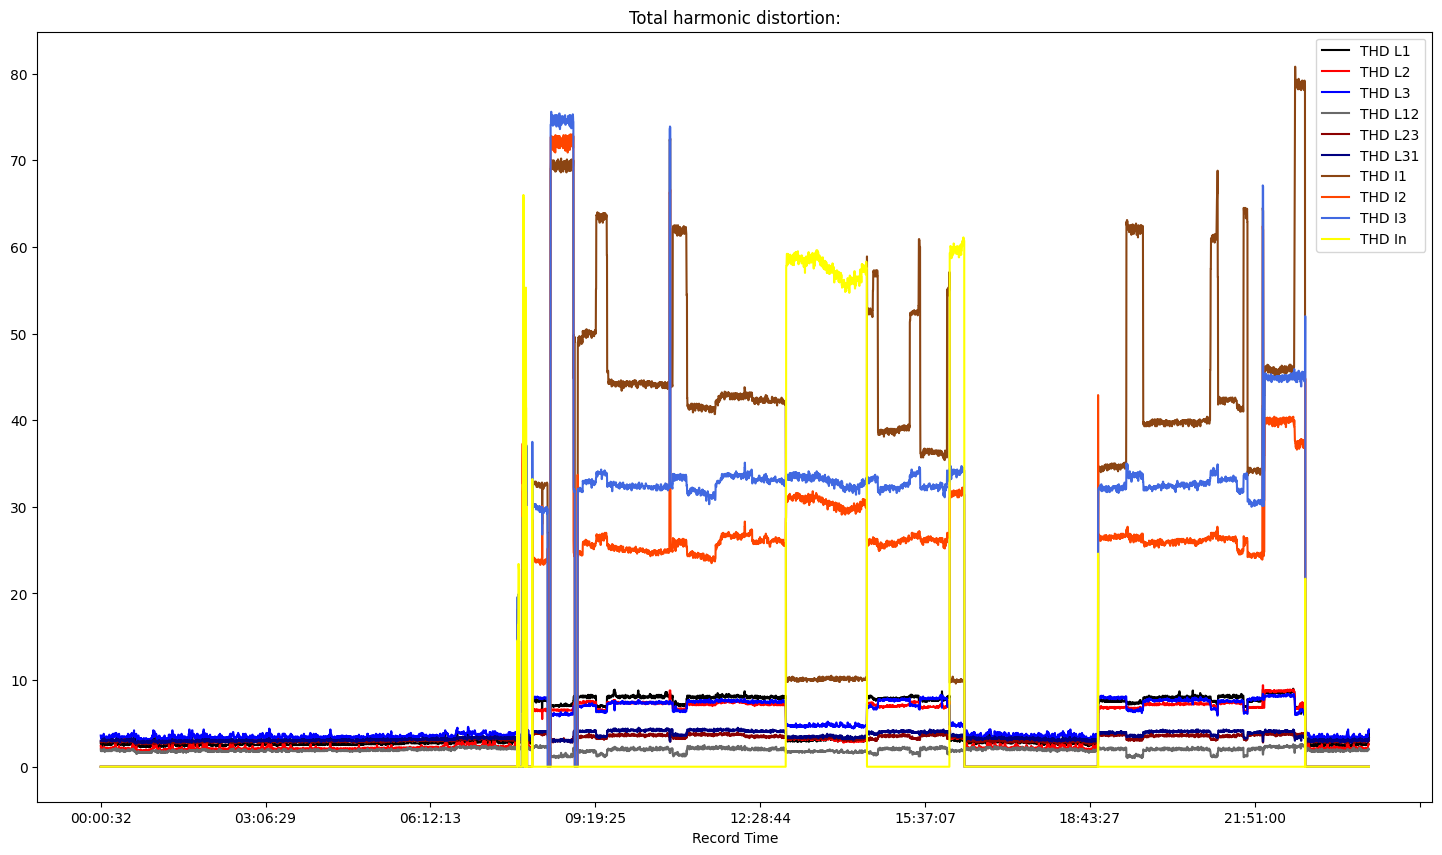

In [32]:
plot_data('THD','line')


# Log Counters
- Import Power
- Export Power
- Inductive Power
- Capacitive Power



# Import / Export Power (kWh)

Import power is the total kWh’s used, export is not always connected, depends on your unit. If the meter is a line connected device export power is not used.

log file column: 
- kWh_Im
- kWh_Ex

In [33]:
get_ptype.append("kWh")
color["kWh"] = {"kWh_Im": "blue", "kWh_Ex": "red"}
title["kWh"]="Import / Export Power (kWh)"


new['kWh'] = pd.concat([df['Record Time'], df["kWh_Im"], df["kWh_Ex"]], axis=1)
new['kWh']


,Record Time,kWh_Im,kWh_Ex
0,00:00:32,491,0
1,00:00:43,491,0
2,00:00:54,491,0
3,00:01:06,491,0
4,00:01:17,491,0
...,...,...,...
7689,23:59:09,713,0
7690,23:59:20,713,0
7691,23:59:31,713,0
7692,23:59:42,713,0


<AxesSubplot: title={'center': 'Import / Export Power (kWh)'}, xlabel='Record Time'>

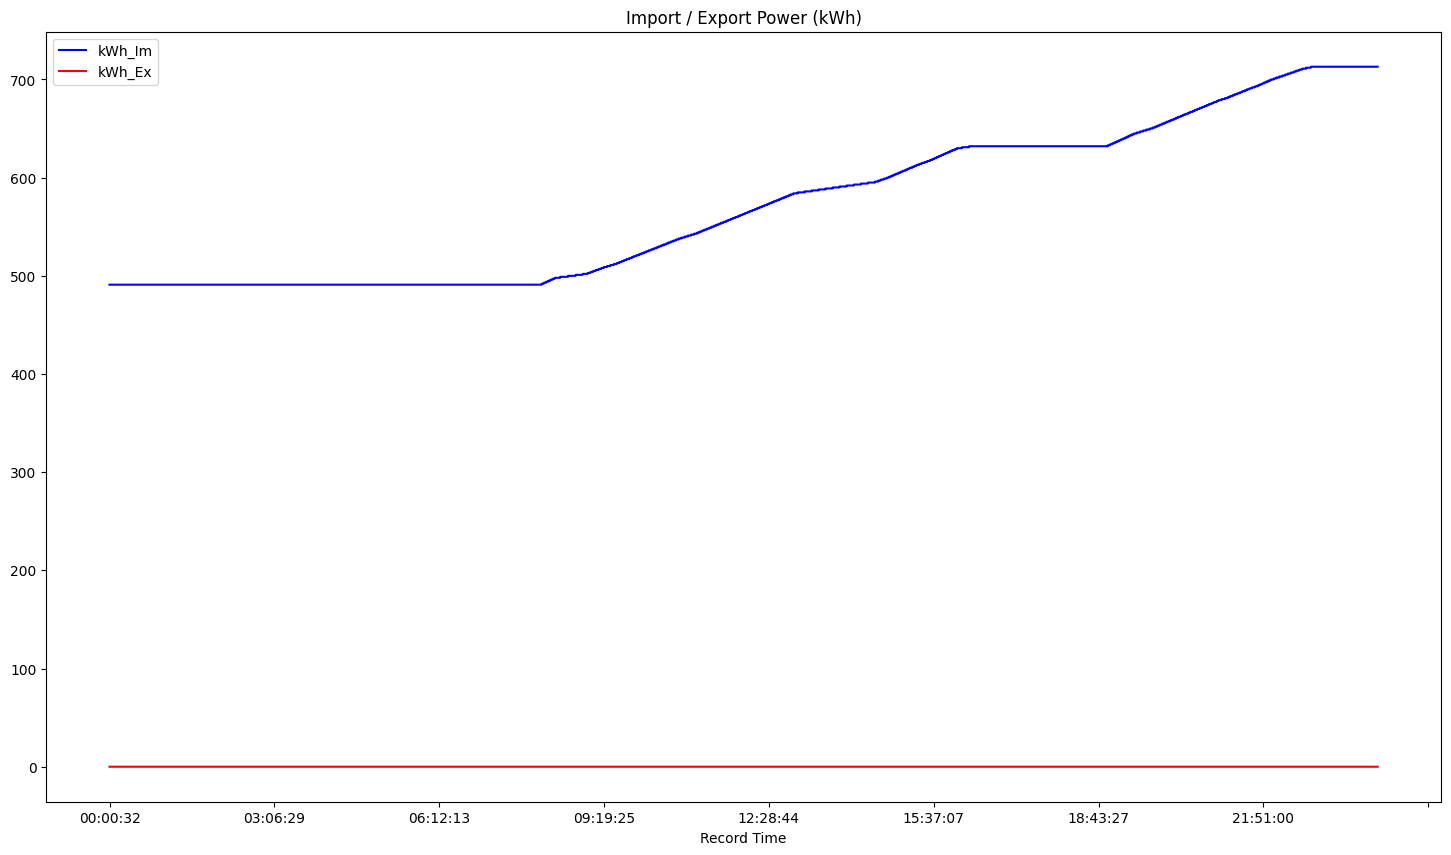

In [34]:
plot_data('kWh','line')


# Inductive / Capacitive Power (kVArh)

Inductive Power and Capacitive Power in kVArh

log file column:
- kVArh-I 
- kVArh-C


In [35]:
get_ptype.append("kVArh")
color["kVArh"] = {'kVArh-I': "blue", 'kVArh-C': "red"}
title["kVArh"]="Inductive / Capacitive Power (kVArh)"
new["kVArh"] = pd.concat([df['Record Time'], df['kVArh-I'], df['kVArh-C']], axis=1)
new["kVArh"]

,Record Time,kVArh-I,kVArh-C
0,00:00:32,40,102
1,00:00:43,40,102
2,00:00:54,40,102
3,00:01:06,40,102
4,00:01:17,40,102
...,...,...,...
7689,23:59:09,192,104
7690,23:59:20,192,104
7691,23:59:31,192,104
7692,23:59:42,192,104


<AxesSubplot: title={'center': 'Inductive / Capacitive Power (kVArh)'}, xlabel='Record Time'>

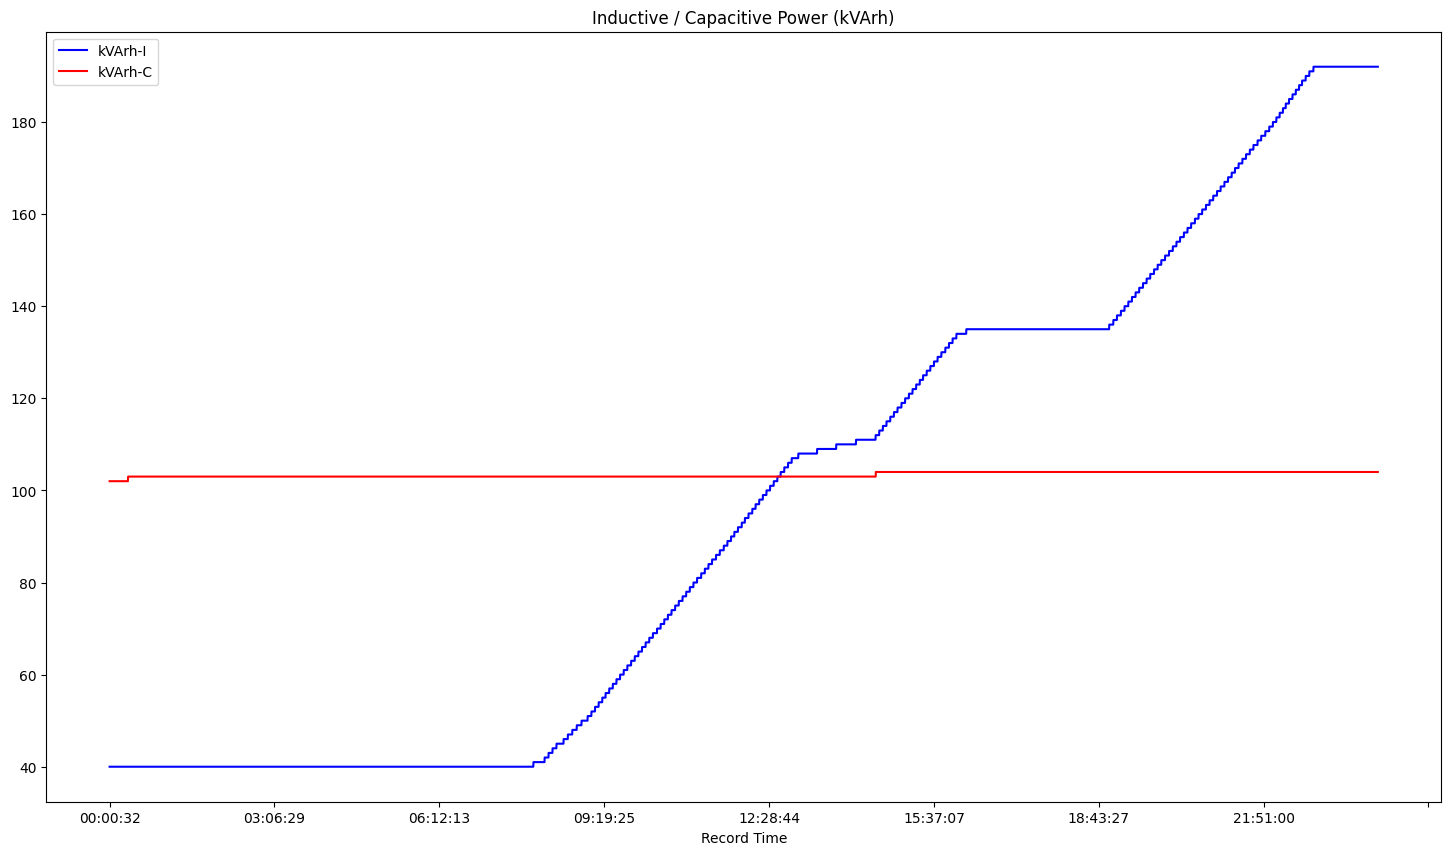

In [36]:
plot_data('kVArh','line')
